# Introduction

This project will explore the OCCP data. Open Charge Point Protocol (OCPP) is an open standard communication protocol for Electric Vehicle (EV) charging stations. It defines interactions between EV charging stations and a central system, helping to facilitate security, transactions, diagnostics, and more.

This dataset if from OCCP v1.6

## Charging System Diagram
Organization < Property < Location < Cluster < Station < UserID

A cluster is a grouping of chargers/stations. This for convenience/load balancing

Each circuit can have multiple clusters.

Each cluster has its own breaker


## Prepare Enviornment

In [3]:
# Access to Google Drive
# This seems to propagate credentials better from its own cell

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Packages and methods

!pip install PyGithub
from github import Github
import os
import datetime
from google.colab import userdata

!pip install pandas pyxlsb
import pandas as pd

import numpy as np

import sys
import logging
import psycopg2

!pip install SQLAlchemy psycopg2-binary
import seaborn as sns
import matplotlib.pyplot as p

import json

import statsmodels.api as sm
from statsmodels.formula.api import ols

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import matplotlib.pyplot as plt

from datetime import timedelta
import holidays

!pip install statsmodels
import statsmodels.api as sm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.9/375.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 24.0 MB/s eta 0:00:00


In [ ]:
# Update github

def colab_to_github(notebook_path, github_repo, folder_path=None, commit_message=None, branch="main"):
   try:
       print("Fetching GitHub token...")
       token = os.getenv('GITHUB_TOKEN')
       if not token:
           raise ValueError("GitHub token is missing or invalid. Ensure it is set as an environment variable.")

       # Add debug logging (only showing first few chars for security)
       print(f"Token format check - starts with: {token[:4]}")

       print("Token successfully retrieved.")
       g = Github(token)
       repo = g.get_repo(github_repo)
       print(f"Connected to repository: {github_repo}")

       if not commit_message:
           commit_message = f"Auto-commit from Colab: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"
       print(f"Using commit message: {commit_message}")

       with open(notebook_path, 'r') as file:
           notebook_content = file.read()
       print(f"Notebook content read from {notebook_path}")

       filename = os.path.basename(notebook_path)
       # Construct the full file path including the folder if specified
       file_path = f"{folder_path}/{filename}" if folder_path else filename
       print(f"Target file path in repo: {file_path}")

       try:
           print(f"Checking if file exists at {file_path}...")
           existing_file = repo.get_contents(file_path, ref=branch)
           repo.update_file(
               path=file_path,
               message=commit_message,
               content=notebook_content,
               sha=existing_file.sha,
               branch=branch
           )
           print(f"File updated successfully in branch '{branch}'.")
       except Exception:
           print(f"File does not exist at {file_path}. Attempting to create...")
           repo.create_file(
               path=file_path,
               message=commit_message,
               content=notebook_content,
               branch=branch
           )
           print(f"File created successfully in branch '{branch}'.")

   except Exception as e:
       print(f"Error occurred: {e}")

raw_token = userdata.get('GITHUB_TOKEN')
cleaned_token = raw_token.replace('token ', '').strip()
print(f"Cleaned token starts with: {cleaned_token[:4]}")

os.environ['GITHUB_TOKEN'] = cleaned_token

# Call the function with your parameters
notebook_path = "/content/drive/MyDrive/Colab Notebooks/OCCP.ipynb"
github_repo = "davidelgas/DataSciencePortfolio"  # This is the correct repository path
folder_path = "OCCP"  # This specifies the directory within the repository
commit_message = "Updated notebook from Colab"

colab_to_github(notebook_path, github_repo, folder_path, commit_message)

Cleaned token starts with: ghp_
Fetching GitHub token...
Token format check - starts with: ghp_
Token successfully retrieved.
Connected to repository: davidelgas/DataSciencePortfolio
Using commit message: Updated notebook from Colab
Notebook content read from /content/drive/MyDrive/Colab Notebooks/OCCP.ipynb
Target file path in repo: OCCP/OCCP.ipynb
Checking if file exists at OCCP/OCCP.ipynb...
File updated successfully in branch 'main'.


## Ingest data

In [ ]:
# import log data

import pandas as pd
import numpy as np

def load_file(file_path):
    """Load a single CSV file."""
    return pd.read_csv(file_path)

def concatenate_files(file_paths):
    """Load and combine multiple CSV files."""
    dfs = []
    for file_path in file_paths:
        df = load_file(file_path)
        if not df.empty:
            dfs.append(df)

    return pd.concat(dfs, ignore_index=True)

if __name__ == "__main__":
    file_paths = [
        '/content/drive/MyDrive/Colab Notebooks/Data_sets/OCCP/sept_100_sample.csv',
        '/content/drive/MyDrive/Colab Notebooks/Data_sets/OCCP/oct_100_sample.csv',
        '/content/drive/MyDrive/Colab Notebooks/Data_sets/OCCP/nov_100_sample.csv',
        '/content/drive/MyDrive/Colab Notebooks/Data_sets/OCCP/dec_100_sample.csv'
    ]

    # Concatenate all files
    df_logs = concatenate_files(file_paths)

    # Save the combined raw data
    df_logs.to_pickle('/content/drive/MyDrive/Colab Notebooks/Data_sets/OCCP/df_logs.pkl')

In [ ]:
# Ingest property tables
import psycopg2
import pandas as pd
import os

# Load credentials
def load_credentials(path_to_credentials):
    with open(path_to_credentials, 'r') as file:
        for line in file:
            if '=' in line:
                key, value = line.split('=', 1)
                os.environ[key.strip()] = value.strip()

# Connection parameters
path_to_credentials = '/content/drive/MyDrive/Colab Notebooks/credentials/aws_credentials.txt'
load_credentials(path_to_credentials)

connection_params = {
    'host': os.getenv('DB_HOST'),
    'dbname': os.getenv('DB_NAME'),
    'user': os.getenv('DB_USER'),
    'password': os.getenv('DB_PASSWORD'),
    'port': os.getenv('DB_PORT')
}

# Connect and fetch data
connection = psycopg2.connect(**connection_params)
cursor = connection.cursor()

# Fetch properties table
cursor.execute("SELECT * FROM properties;")
properties_df = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])
properties_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Data_sets/OCCP/properties.csv', index=False)

# Fetch property_types table
cursor.execute("SELECT * FROM property_types;")
property_types_df = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])
property_types_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Data_sets/OCCP/property_types.csv', index=False)

# Close connection
cursor.close()
connection.close()

In [ ]:
# import property data
import pandas as pd

def process_properties(file_path, output_path):
    """Process properties file workflow."""
    # Load CSV
    df_prop = pd.read_csv(file_path)

    # Clean IDs
    df_prop = df_prop[df_prop['id'].notna()].reset_index(drop=True)

    # Rename id column
    df_prop = df_prop.rename(columns={'id': 'property_id'})

    # Save processed data
    df_prop.to_pickle(output_path_3 + '.pkl')

    return df_prop

if __name__ == "__main__":
    input_path_3 = '/content/drive/MyDrive/Colab Notebooks/Data_sets/OCCP/properties.csv'
    output_path_3 = '/content/drive/MyDrive/Colab Notebooks/Data_sets/OCCP/df_prop'

    # Run workflow
    df_prop = process_properties(input_path_3, output_path_3)


In [ ]:
# import prop size data
# This is from Salesforce

import pandas as pd

def clean_record_id(record_id):
   return str(record_id).replace('zcrm_', '') if pd.notna(record_id) else record_id

def process_property_sizes(file_path, output_path):
   """Process property size file workflow."""
   # Load CSV with explicit encoding
   df_prop_size = pd.read_csv(file_path, encoding='latin-1')

   # Rename columns
   df_prop_size = df_prop_size.rename(columns={
       'Record Id': 'Record_id_lg',
       'Record Id (Managed Account)': 'Record_id_js'
   })

   # Clean IDs by removing 'zcrm_' prefix directly in the existing column
   df_prop_size['Record_id_js'] = df_prop_size['Record_id_js'].apply(clean_record_id)

   # Clean IDs
   df_prop_size = df_prop_size[df_prop_size['Record_id_js'].notna()].reset_index(drop=True)

   # Cast id to object type
   df_prop_size = df_prop_size.astype({'Record_id_js': 'object'})

   # Save processed data
   df_prop_size.to_pickle(output_path + '.pkl')

   return df_prop_size

if __name__ == "__main__":
   input_path_2 = '/content/drive/MyDrive/Colab Notebooks/Data_sets/OCCP/All_Viable_Accounts_JS.csv'
   output_path_2 = '/content/drive/MyDrive/Colab Notebooks/Data_sets/OCCP/df_prop_size'

   # Run workflow
   df_prop_size = process_property_sizes(input_path_2, output_path_2)

In [ ]:
# import prop type data
# This is from AWS

import pandas as pd

def clean_record_id(record_id):
   """
   Remove 'zcrm_' prefix from Record Id
   """
   return str(record_id).replace('zcrm_', '') if pd.notna(record_id) else record_id

def process_property_types(file_path, output_path):
   # Load CSV with explicit encoding
   df_types = pd.read_csv(file_path, encoding='latin-1')

   # Rename columns
 #  df_prop_size = df_prop_size.rename(columns={
  #     'Record Id': 'Record_id_lg',
 #      'Record Id (Managed Account)': 'Record_id_js'
  # })

  # # Clean IDs by removing 'zcrm_' prefix directly in the existing column
 #  df_prop_size['Record_id_js'] = df_prop_size['Record_id_js'].apply(clean_record_id)

  # # Clean IDs
  # df_prop_size = df_prop_size[df_prop_size['Record_id_js'].notna()].reset_index(drop=True)

   # Cast id to object type
  # df_prop_size = df_prop_size.astype({'Record_id_js': 'object'})

   # Save processed data
   df_types.to_pickle(output_path + '.pkl')

   return df_types

if __name__ == "__main__":
   input_path_2 = '/content/drive/MyDrive/Colab Notebooks/Data_sets/OCCP/property_types.csv'
   output_path_2 = '/content/drive/MyDrive/Colab Notebooks/Data_sets/OCCP/df_prop_type'

   # Run workflow
   df_types = process_property_types(input_path_2, output_path_2)

## Clean data

In [ ]:
# Here are the dfs Ill be working with

df_logs = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Data_sets/OCCP/df_logs.pkl')
df_prop = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Data_sets/OCCP/df_prop.pkl')
df_prop_size = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Data_sets/OCCP/df_prop_size.pkl')
df_prop_type = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Data_sets/OCCP/df_prop_type.pkl')

###This is what the JSON field looks like



{"connectorId":1,"transactionId":1417592169,"meterValue":[{"timestamp":"2025-01-14T13:27:37.145Z","sampledValue":[{"value":"31323855.0","context":"Sample.Periodic","format":"Raw","measurand":"Energy.Active.Import.Register","phase":"L1","location":"Outlet","unit":"Wh"},{"value":"0.00","context":"Sample.Periodic","format":"Raw","measurand":"Current.Import","phase":"L1","location":"Outlet","unit":"A"},{"value":"240.57","context":"Sample.Periodic","format":"Raw","measurand":"Voltage","phase":"L1","location":"Outlet","unit":"V"},{"value":"28","context":"Sample.Periodic","format":"Raw","measurand":"Temperature","phase":null,"location":"Body","unit":"Celsius"},{"value":"6.00","context":"Sample.Periodic","format":"Raw","measurand":"Current.Offered","phase":"L1","location":"Outlet","unit":"A"},{"value":"1440.00","context":"Sample.Periodic","format":"Raw","measurand":"Power.Offered","phase":"L1","location":"Outlet","unit":"W"},{"value":"0.00","context":"Sample.Periodic","format":"Raw","measurand":"Power.Active.Import","phase":"L1","location":"Outlet","unit":"W"}]}]}

In [ ]:
# Unpack the JSON in the log file
import pandas as pd
import json

def expand_message_json(df):
    rows = []

    for idx, row in df.iterrows():
        # Parse the JSON message
        message = json.loads(row['cleaned_message']) if pd.notna(row['cleaned_message']) else {}

        # Get transactionId from the message
        transaction_id = message.get('transactionId')

        # Extract meter values
        meter_values = message.get('meterValue', [])
        for meter in meter_values:
            timestamp = meter.get('timestamp')
            sampled_values = meter.get('sampledValue', [])

            # Filter for only A and W units
            for sample in sampled_values:
                unit = sample.get('unit')
                if unit in ['A', 'W']:
                    rows.append({
                        'property_id': row['property_id'],
                        'user_id': row['user_id'],
                        'transaction_id': transaction_id,  # Fixed variable name here
                        'timestamp': timestamp,
                        'value': sample.get('value'),
                        'unit': unit
                    })

    return pd.DataFrame(rows)

# Expand the JSON column
df_logs_exp = expand_message_json(df_logs)

# Save the expanded data
df_logs_exp.to_pickle('/content/drive/MyDrive/Colab Notebooks/Data_sets/OCCP/df_logs_exp.pkl')

# Expand the JSON column
df_logs_exp = expand_message_json(df_logs)

# Save the expanded data
df_logs_exp.to_pickle('/content/drive/MyDrive/Colab Notebooks/Data_sets/OCCP/df_logs_exp.pkl')


In [ ]:
# Normalize column naming

df_prop_type = df_prop_type.rename(columns={'id': 'property_id'})
df_prop_type = df_prop_type.rename(columns={'name': 'prop_type'})



In [ ]:
# Check join logic
# Does df_prop.managed_account_id join with df_prop_size.Record_id_js

# Check overlap between the two columns
total_managed_accounts = len(df_prop['managed_account_id'].unique())
total_record_ids = len(df_prop_size['Record_id_js'].unique())

# Check for matches
common_ids = set(df_prop['managed_account_id']) & set(df_prop_size['Record_id_js'])
total_matches = len(common_ids)

print(f"Unique values in df_prop.managed_account_id: {total_managed_accounts:,}")
print(f"Unique values in df_prop_size.Record_id_js: {total_record_ids:,}")
print(f"Number of matching IDs: {total_matches:,}")

# Calculate percentages
match_pct_prop = (total_matches / total_managed_accounts) * 100
match_pct_size = (total_matches / total_record_ids) * 100

print(f"\nPercentage of df_prop.managed_account_id with matches: {match_pct_prop:.1f}%")
print(f"Percentage of df_prop_size.Record_id_js with matches: {match_pct_size:.1f}%")

# Generally speaking, yes



# Check join logic
# Does df_prop.property_type join with df_prop_type.property_id

total_prop_types = len(df_prop['property_type'].unique())
total_prop_ids = len(df_prop_type['property_id'].unique())

# Check for matches
common_ids = set(df_prop['property_type']) & set(df_prop_type['property_id'])
total_matches = len(common_ids)

print(f"Unique values in df_prop.property_type: {total_prop_types:,}")
print(f"Unique values in df_prop_type.property_id: {total_prop_ids:,}")
print(f"Number of matching IDs: {total_matches:,}")

# Calculate percentages
match_pct_prop = (total_matches / total_prop_types) * 100
match_pct_type = (total_matches / total_prop_ids) * 100

print(f"\nPercentage of df_prop.property_type with matches: {match_pct_prop:.1f}%")
print(f"Percentage of df_prop_type.property_id with matches: {match_pct_type:.1f}%")

# Generally speaking, yes



# Check join logic
# Does df_logs.property_id join with df_prop.property_id

# Check overlap between the two columns
total_log_ids = len(df_logs['property_id'].unique())
total_type_ids = len(df_prop['property_id'].unique())

# Check for matches
common_ids = set(df_logs['property_id']) & set(df_prop['property_id'])
total_matches = len(common_ids)

print(f"Unique values in df_logs.property_id: {total_log_ids:,}")
print(f"Unique values in df_prop_type.property_id: {total_type_ids:,}")
print(f"Number of matching IDs: {total_matches:,}")

# Calculate percentages
match_pct_logs = (total_matches / total_log_ids) * 100
match_pct_type = (total_matches / total_type_ids) * 100

print(f"\nPercentage of df_logs.property_id with matches: {match_pct_logs:.1f}%")
print(f"Percentage of df_prop_type.property_id with matches: {match_pct_type:.1f}%")

In [ ]:
# Update log df with property metadata

# Load the logs data from pickle
df_logs_exp = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Data_sets/OCCP/df_logs_exp.pkl')


def create_property_metadata(df_prop):
    # Select only the required columns
    df_metadata = df_prop[['property_id', 'property_type', 'managed_account_id']]
    return df_metadata

def append_property_type_name(df_metadata, df_prop_type):
    df_metadata = df_metadata.merge(
        df_prop_type[['property_id', 'prop_type']],
        left_on='property_type',
        right_on='property_id',
        how='left'
    )

    # Drop redundant property_id column and rename property_id_x
    df_metadata = df_metadata.drop(columns=['property_id_y'])
    df_metadata = df_metadata.rename(columns={'property_id_x': 'property_id'})

    return df_metadata

def append_parking_spaces(df_metadata, df_prop_size):
    df_metadata = df_metadata.merge(
        df_prop_size[['Record_id_js', 'Total Parking Space Count']],
        left_on='managed_account_id',
        right_on='Record_id_js',
        how='left'
    )

    # Drop redundant join key and rename parking spaces column
    df_metadata = df_metadata.drop(columns=['Record_id_js'])
    df_metadata = df_metadata.rename(columns={'Total Parking Space Count': 'parking_spaces'})

    return df_metadata

def append_metadata_to_logs(df_logs, df_prop_metadata):
    """
    Append property metadata to logs using property_id as join key.
    Left join preserves all logs records.
    """
    df_logs_enriched = df_logs.merge(
        df_prop_metadata,
        on='property_id',
        how='left'
    )

    return df_logs_enriched

def process_and_save_enriched_logs(df_prop, df_prop_type, df_prop_size, df_logs, output_path):
    """Process metadata and logs workflow and save to pickle."""

    # Ingest df
    df_logs_exp.to_pickle('/content/drive/MyDrive/Colab Notebooks/Data_sets/OCCP/df_logs_exp.pkl')

    # Create metadata table
    df_prop_metadata = create_property_metadata(df_prop)

    # Append property type name
    df_prop_metadata = append_property_type_name(df_prop_metadata, df_prop_type)

    # Append parking spaces
    df_prop_metadata = append_parking_spaces(df_prop_metadata, df_prop_size)

    # Append metadata to logs
    df_logs_enriched = append_metadata_to_logs(df_logs, df_prop_metadata)

    # Save enriched logs to pickle
    df_logs_enriched.to_pickle(output_path + '.pkl')

    return df_logs_enriched

if __name__ == "__main__":
    # Define output path
    enriched_logs_output = '/content/drive/MyDrive/Colab Notebooks/Data_sets/OCCP/df_logs_enriched'

    # Run workflow and save enriched logs
    df_logs_enriched = process_and_save_enriched_logs(
        df_prop,
        df_prop_type,
        df_prop_size,
        df_logs_exp,
        enriched_logs_output
    )

    # Print final shapes to verify
    print("Original logs shape:", df_logs.shape)
    print("Enriched logs shape:", df_logs_enriched.shape)
    print("\nNew columns added from metadata:", sorted(set(df_logs_enriched.columns) - set(df_logs.columns)))

df_logs_enriched.info()


In [ ]:
# Remove rows with Null data and convert timestamp to UTC
import numpy as np

df_logs_enriched = df_logs_enriched.replace([np.inf, -np.inf], np.nan)
df_logs_enriched = df_logs_enriched.dropna()
df_logs_enriched = df_logs_enriched[['property_id','prop_type','parking_spaces','user_id','transaction_id','timestamp','unit','value']]

# Convert timestamp to UTC
df_logs_enriched['timestamp'] = pd.to_datetime(df_logs_enriched['timestamp'], format='ISO8601', utc=True)

# Save the cleaned dataframe
df_logs_enriched.to_pickle('/content/drive/MyDrive/Colab Notebooks/Data_sets/OCCP/df_logs_enriched.pkl')

# Flatten, encode
# One-hot encode 'prop_type' with 1/0 values
df_logs_enriched = pd.get_dummies(df_logs_enriched, columns=['prop_type'], prefix='prop_type', dtype=int)

# Binary encode unit (0 for 'A', 1 for 'W') - being explicit about handling NaN
df_logs_enriched['unit_encoded'] = df_logs_enriched['unit'].map({'A': 0, 'W': 1}).fillna(0).astype(int)
df_logs_enriched = df_logs_enriched.drop('unit', axis=1)


# Save processed data
output_path = '/content/drive/MyDrive/Colab Notebooks/Data_sets/OCCP/df_logs_enriched'

df_logs_enriched.to_pickle(output_path + '.pkl')

## Data Exploration

In [ ]:
# Check unique timestamp formats
print("Sample of unique timestamp formats:")
print(df_logs_enriched['timestamp'].drop_duplicates().head(10))

# Group by transaction_id and get min/max timestamps
time_spans = df_logs_enriched.groupby('transaction_id').agg({
   'timestamp': ['min', 'max']
}).reset_index()

# Calculate duration for each transaction
time_spans['duration'] = time_spans['timestamp']['max'] - time_spans['timestamp']['min']

# Calculate different time spans
spans = {
   'different_days': time_spans['duration'] >= pd.Timedelta(days=1),
   'different_hours': time_spans['duration'] >= pd.Timedelta(hours=1),
   'different_minutes': time_spans['duration'] >= pd.Timedelta(minutes=1),
   'different_seconds': time_spans['duration'] >= pd.Timedelta(seconds=1),
   'different_milliseconds': time_spans['duration'] >= pd.Timedelta(milliseconds=1)
}

# Count transactions in each category
for span_type, mask in spans.items():
   count = mask.sum()
   percent = (count / len(time_spans)) * 100
   print(f"Transactions spanning {span_type}: {count:,} ({percent:.2f}%)")

print("\nDuration statistics:")
print(time_spans['duration'].describe())

# Additional context
print("\nTotal transactions analyzed:", len(time_spans))

Sample of unique timestamp formats:
0    2024-09-30 09:38:40.755000+00:00
1    2024-09-30 09:38:41.089000+00:00
2    2024-09-30 09:38:21.379000+00:00
6    2024-09-30 09:38:21.661000+00:00
10   2024-09-30 09:38:06.463000+00:00
11   2024-09-30 09:38:03.114000+00:00
12   2024-09-30 09:38:01.108000+00:00
13   2024-09-30 09:38:01.586000+00:00
14   2024-09-30 09:37:59.171000+00:00
17   2024-09-30 09:37:50.642000+00:00
Name: timestamp, dtype: datetime64[ns, UTC]
Transactions spanning different_days: 3,691 (3.16%)
Transactions spanning different_hours: 94,656 (80.95%)
Transactions spanning different_minutes: 106,744 (91.29%)
Transactions spanning different_seconds: 106,872 (91.40%)
Transactions spanning different_milliseconds: 106,872 (91.40%)

Duration statistics:
count                       116929
mean     0 days 07:52:18.698677282
std      0 days 12:52:44.181133458
min                0 days 00:00:00
25%         0 days 01:36:29.999000
50%                0 days 05:46:00
75%         0 days 10:

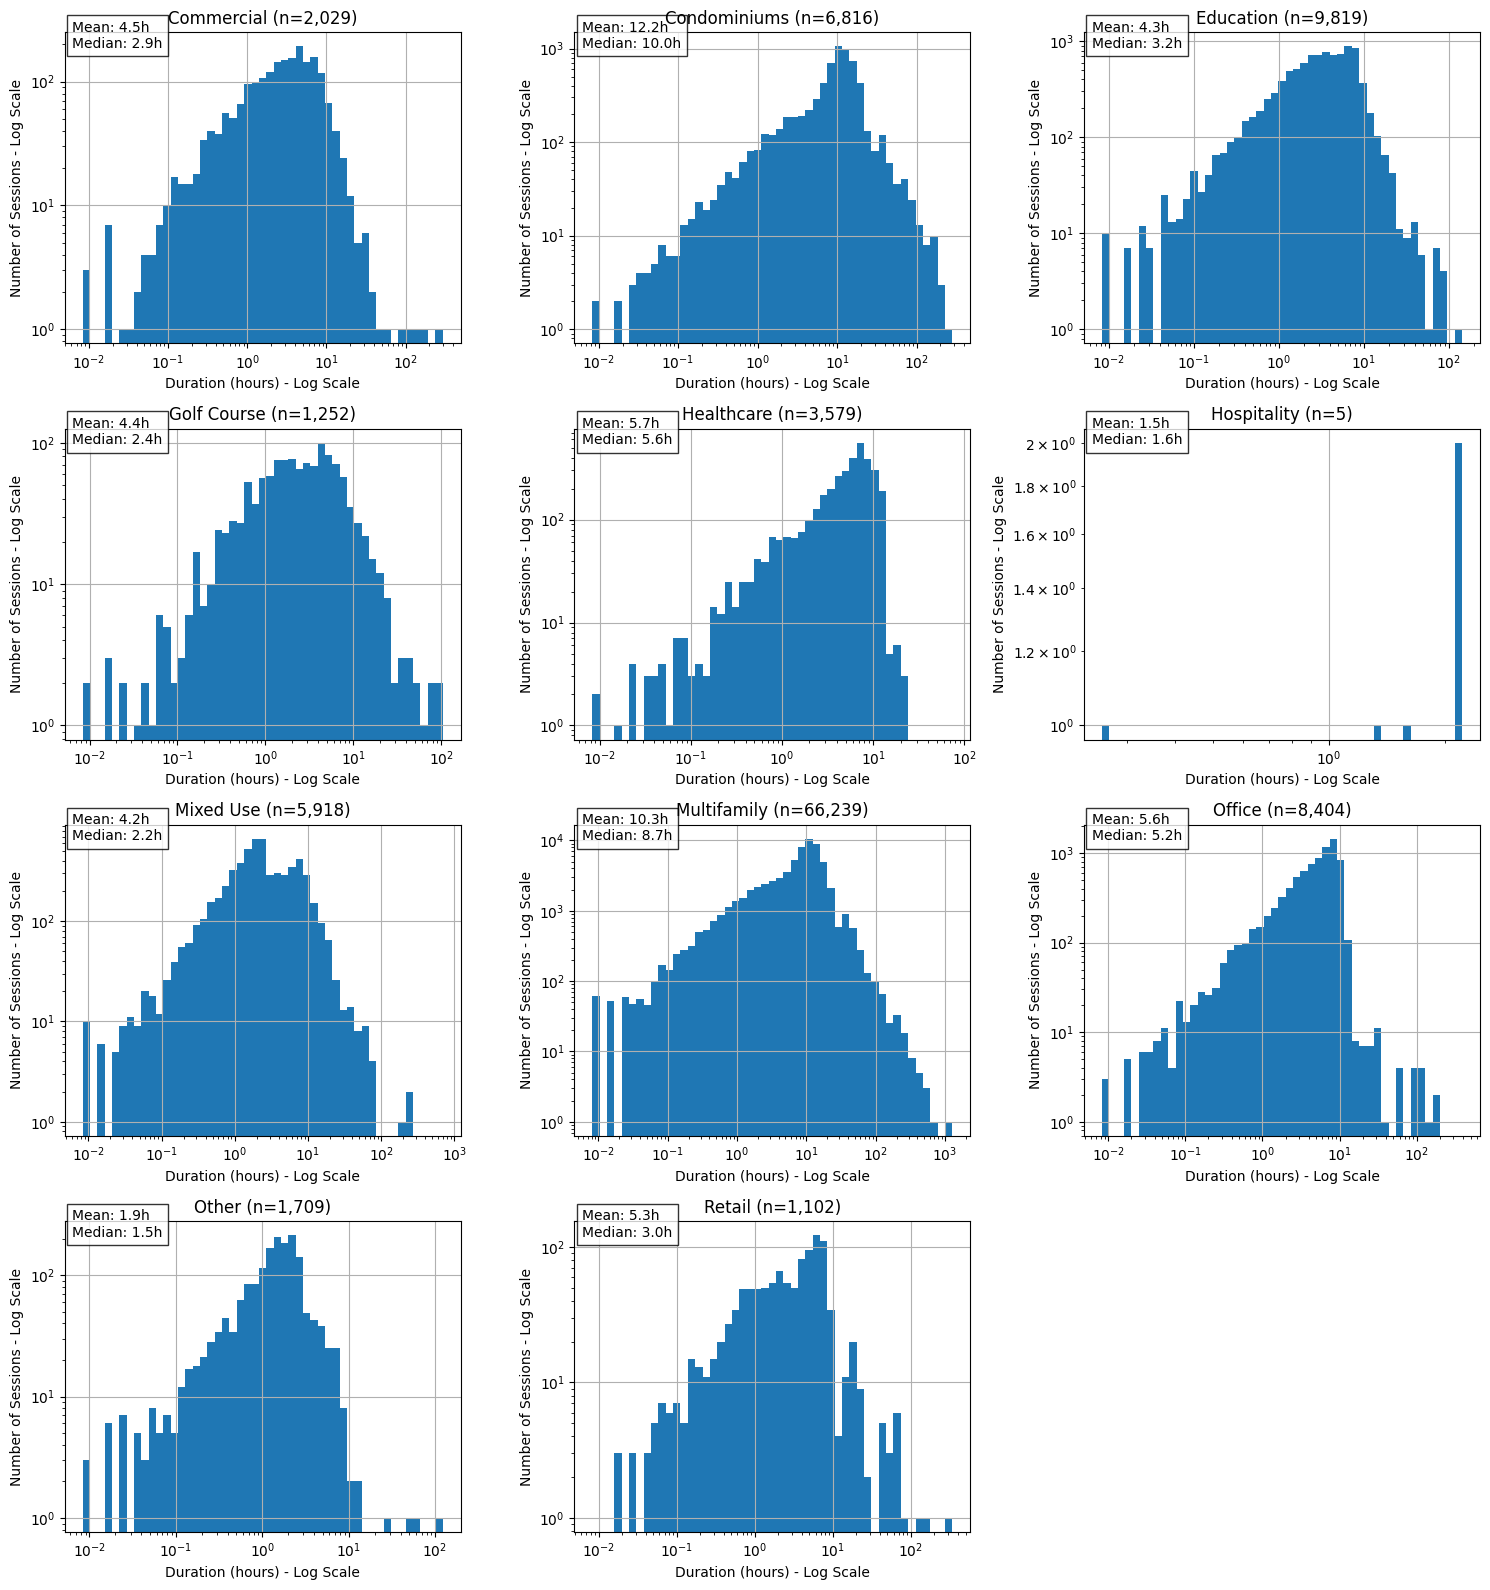


Summary statistics by property type:

Commercial:
count    2029.000000
mean        4.481265
std         9.551752
min         0.008333
25%         1.191667
50%         2.941667
75%         5.558333
max       293.358194
Name: duration_hours, dtype: float64

Condominiums:
count    6816.000000
mean       12.153338
std        14.768043
min         0.008333
25%         5.166667
50%        10.004166
75%        14.285417
max       281.716667
Name: duration_hours, dtype: float64

Education:
count    9819.000000
mean        4.302011
std         4.901593
min         0.008333
25%         1.470833
50%         3.175000
75%         6.083333
max       143.816667
Name: duration_hours, dtype: float64

Golf Course:
count    1252.000000
mean        4.413292
std         7.746019
min         0.008333
25%         1.008333
50%         2.366667
75%         5.204191
max       103.833333
Name: duration_hours, dtype: float64

Healthcare:
count    3579.000000
mean        5.690115
std         3.604723
min         

In [ ]:
# Compare usae data across property types

import matplotlib.pyplot as plt
import numpy as np

# First ensure timestamps are datetime
df_logs_enriched['timestamp'] = pd.to_datetime(df_logs_enriched['timestamp'], format='ISO8601')

# Create time_spans from df_logs_enriched
time_spans = df_logs_enriched.groupby('transaction_id').agg({
    'timestamp': ['min', 'max'],
    'property_id': 'first'  # keep property_id for merging
}).reset_index()

time_spans.columns = ['transaction_id', 'min_time', 'max_time', 'property_id']
time_spans['duration'] = time_spans['max_time'] - time_spans['min_time']
time_spans['duration_hours'] = time_spans['duration'].dt.total_seconds() / 3600

# Merge with property types from df_logs_enriched
prop_type_cols = [col for col in df_logs_enriched.columns if col.startswith('prop_type_')]
durations_with_type = time_spans.merge(
    df_logs_enriched[['property_id'] + prop_type_cols].drop_duplicates(),
    on='property_id'
)

# Create subplot for each property type
n_types = len(prop_type_cols)
n_cols = 3
n_rows = (n_types + n_cols - 1) // n_cols

plt.figure(figsize=(15, 4*n_rows))

for idx, prop_type in enumerate(prop_type_cols, 1):
    plt.subplot(n_rows, n_cols, idx)

    # Get durations for this property type
    type_durations = durations_with_type[durations_with_type[prop_type] == 1]['duration_hours']
    type_durations = type_durations[type_durations > 0]  # Filter positive durations

    if len(type_durations) > 0:  # Only plot if we have data
        plt.hist(type_durations,
                bins=np.logspace(np.log10(type_durations.min()),
                               np.log10(type_durations.max()),
                               50))
        plt.xscale('log')
        plt.yscale('log')

        plt.title(f'{prop_type.replace("prop_type_", "")} (n={len(type_durations):,})')
        plt.xlabel('Duration (hours) - Log Scale')
        plt.ylabel('Number of Sessions - Log Scale')
        plt.grid(True)

        # Add statistics
        plt.text(0.02, 0.95,
                f'Mean: {type_durations.mean():.1f}h\n'
                f'Median: {type_durations.median():.1f}h',
                transform=plt.gca().transAxes,
                bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print summary statistics by property type
print("\nSummary statistics by property type:")
for prop_type in prop_type_cols:
    type_durations = durations_with_type[durations_with_type[prop_type] == 1]['duration_hours']
    type_durations = type_durations[type_durations > 0]
    if len(type_durations) > 0:
        print(f"\n{prop_type.replace('prop_type_', '')}:")
        print(type_durations.describe())

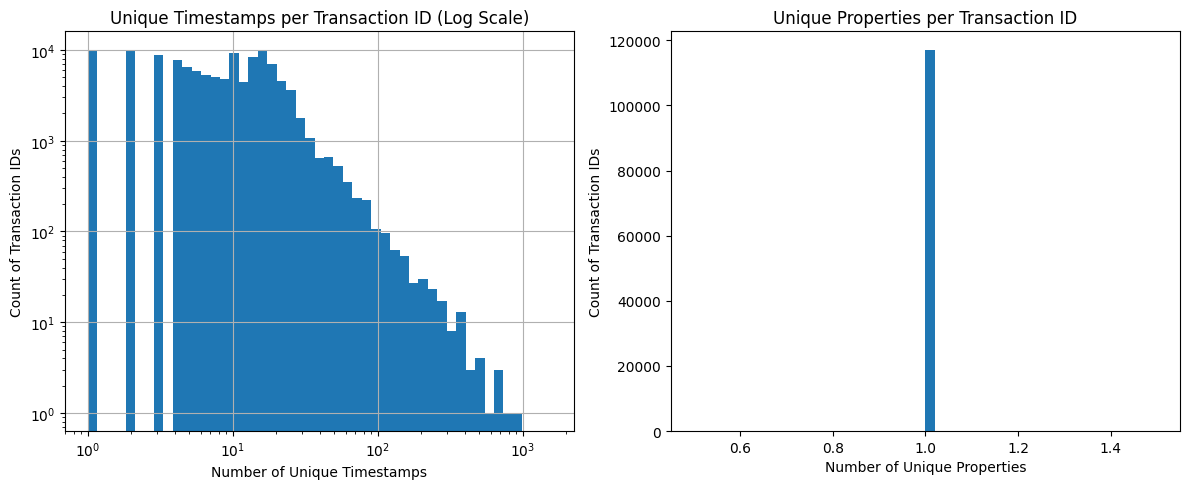


Timestamps per transaction summary:
count    116929.000000
mean         11.343379
std          15.791565
min           1.000000
25%           4.000000
50%           8.000000
75%          15.000000
max        1557.000000
Name: timestamp, dtype: float64

Properties per transaction summary:
count    116929.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: property_id, dtype: float64

Total number of unique transactions: 116929
Total number of unique properties: 552
Total number of timestamps: 1326257


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Histogram of timestamps per transaction_id
timestamps_per_transaction = df_logs_enriched.groupby('transaction_id')['timestamp'].nunique()

plt.figure(figsize=(12, 5))

# Left plot - log scale
plt.subplot(1, 2, 1)
plt.hist(timestamps_per_transaction, bins=np.logspace(np.log10(1), np.log10(timestamps_per_transaction.max()), 50))
plt.xscale('log')
plt.yscale('log')
plt.title('Unique Timestamps per Transaction ID (Log Scale)')
plt.xlabel('Number of Unique Timestamps')
plt.ylabel('Count of Transaction IDs')
plt.grid(True)

# Right plot - properties per transaction
properties_per_transaction = df_logs_enriched.groupby('transaction_id')['property_id'].nunique()
plt.subplot(1, 2, 2)
plt.hist(properties_per_transaction, bins=50)
plt.title('Unique Properties per Transaction ID')
plt.xlabel('Number of Unique Properties')
plt.ylabel('Count of Transaction IDs')

plt.tight_layout()
plt.show()

print("\nTimestamps per transaction summary:")
print(timestamps_per_transaction.describe())
print("\nProperties per transaction summary:")
print(properties_per_transaction.describe())

# Print additional context
print("\nTotal number of unique transactions:", len(timestamps_per_transaction))
print("Total number of unique properties:", df_logs_enriched['property_id'].nunique())
print("Total number of timestamps:", df_logs_enriched['timestamp'].nunique())

## Engineer Features

In [ ]:
import pandas as pd
import pytz
import numpy as np
from datetime import datetime

def convert_to_pst_components(df):
    """Convert timestamp to PST and extract components."""
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='ISO8601')
    df['timestamp'] = df['timestamp'].dt.tz_convert('US/Pacific')

    df['year'] = df['timestamp'].dt.year
    df['month'] = df['timestamp'].dt.month
    df['day'] = df['timestamp'].dt.day
    df['hour'] = df['timestamp'].dt.hour
    df['minute'] = df['timestamp'].dt.minute

    return df

def add_day_info(df):
    """Add day of week and weekend indicator."""
    df['day_of_week'] = df['timestamp'].dt.dayofweek + 1
    df['day_weekend'] = (df['day_of_week'] >= 6).astype(int)
    return df

def get_nearest_holiday(df):
    """Calculate proximity to major US holidays."""
    major_holidays = {
        '2024-01-01': "New Year's Day",
        '2024-01-15': "Martin Luther King Jr. Day",
        '2024-02-19': "Presidents Day",
        '2024-05-27': "Memorial Day",
        '2024-07-04': "Independence Day",
        '2024-09-02': "Labor Day",
        '2024-11-28': "Thanksgiving",
        '2024-12-25': "Christmas",
        '2025-01-01': "New Year's Day",
        '2025-01-20': "Martin Luther King Jr. Day",
        '2025-02-17': "Presidents Day",
        '2025-05-26': "Memorial Day",
        '2025-07-04': "Independence Day",
        '2025-09-01': "Labor Day",
        '2025-11-27': "Thanksgiving",
        '2025-12-25': "Christmas"
    }

    holiday_dates = pd.to_datetime(list(major_holidays.keys())).sort_values()
    holiday_dates_array = holiday_dates.values
    dates_array = pd.to_datetime(df['timestamp'].dt.date.unique()).values
    holiday_lookup = {}

    for date in dates_array:
        days_diff = np.abs((holiday_dates_array - date).astype('timedelta64[D]').astype(int))
        closest_idx = np.argmin(days_diff)
        closest_date = holiday_dates[closest_idx]

        holiday_lookup[pd.Timestamp(date).date()] = {
            'days_to_nearest_holiday': days_diff[closest_idx],
            'nearest_holiday_date': closest_date,
            'nearest_holiday_name': major_holidays[closest_date.strftime('%Y-%m-%d')]
        }

    # Create and merge holiday information
    df['date'] = df['timestamp'].dt.date
    result = pd.DataFrame.from_dict(holiday_lookup, orient='index')
    result.index = pd.to_datetime(result.index).date
    df = df.merge(result, left_on='date', right_index=True)
    df = df.drop('date', axis=1)

    return df

def process_timestamps(input_path, output_path):
    """Main function to process all timestamp-related features."""
    df = pd.read_pickle(input_path)
    df = convert_to_pst_components(df)
    df = add_day_info(df)
    df = get_nearest_holiday(df)
    df.to_pickle(output_path)
    return df

if __name__ == "__main__":
    input_path = '/content/drive/MyDrive/Colab Notebooks/Data_sets/OCCP/df_logs_enriched.pkl'
    output_path = '/content/drive/MyDrive/Colab Notebooks/Data_sets/OCCP/df_logs_enriched_with_holidays.pkl'

    df_processed = process_timestamps(input_path, output_path)
    print(f"Processing complete. File saved to: {output_path}")

In [ ]:

# Add user and usage data
import pandas as pd

def add_unique_user_counts(df, group_cols, user_col):
    """Count unique users per group."""
    user_counts = df.groupby(group_cols)[user_col].nunique().reset_index()
    user_counts.rename(columns={user_col: 'unique_user_count'}, inplace=True)
    df = df.merge(user_counts, on=group_cols, how='left')
    return df

def add_usage_sums(df, group_cols):
    """Add sums of values for each unit type by group."""
    # Calculate sums for each unit type
    sums = df.groupby([*group_cols, 'unit_encoded'])['value'].sum().reset_index()

    # Pivot to create separate columns for A and W
    sums = sums.pivot(
        index=group_cols,
        columns='unit_encoded',
        values='value'
    ).reset_index()

    # Rename columns
    sums.rename(
        columns={
            0: 'sum_value_A',   # Amps were encoded as 0
            1: 'sum_value_Wh'   # Watts were encoded as 1
        },
        inplace=True
    )

    return df.merge(sums, on=group_cols, how='left')

if __name__ == "__main__":
    input_path = '/content/drive/MyDrive/Colab Notebooks/Data_sets/OCCP/df_logs_enriched_with_holidays.pkl'
    output_path = '/content/drive/MyDrive/Colab Notebooks/Data_sets/OCCP/df_logs_enriched_with_usage.pkl'

    # Read data
    df = pd.read_pickle(input_path)

    # Extract datetime components
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['year'] = df['timestamp'].dt.year
    df['month'] = df['timestamp'].dt.month
    df['day'] = df['timestamp'].dt.day
    df['hour'] = df['timestamp'].dt.hour

    # Define grouping columns after datetime components are created
    group_cols = ['property_id', 'year', 'month', 'day', 'hour']

    # Add user and usage metrics
    df = add_unique_user_counts(df, group_cols, 'user_id')
    df = add_usage_sums(df, group_cols)

    # Save results
    df.to_pickle(output_path)
    print(f"Processing complete. File saved to: {output_path}")

Processing complete. File saved to: /content/drive/MyDrive/Colab Notebooks/Data_sets/OCCP/df_logs_enriched_with_usage.pkl


In [ ]:
df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Data_sets/OCCP/df_logs_enriched_with_usage.pkl')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2446083 entries, 0 to 2446082
Data columns (total 31 columns):
 #   Column                   Dtype                     
---  ------                   -----                     
 0   property_id              object                    
 1   parking_spaces           float64                   
 2   user_id                  object                    
 3   transaction_id           int64                     
 4   timestamp                datetime64[ns, US/Pacific]
 5   value                    object                    
 6   prop_type_Commercial     int64                     
 7   prop_type_Condominiums   int64                     
 8   prop_type_Education      int64                     
 9   prop_type_Golf Course    int64                     
 10  prop_type_Healthcare     int64                     
 11  prop_type_Hospitality    int64                     
 12  prop_type_Mixed Use      int64                     
 13  prop_type_Multifamily    in

In [ ]:
# Halt
sys.exit()

## Check for colinearity


Column: day_of_week
Null values after conversion: 0
Sample unique values: [2, 2, 6, 1, 3]

Column: days_to_nearest_holiday
Null values after conversion: 0
Sample unique values: [17, 0, 4, 12, 2]

Column: month
Null values after conversion: 0
Sample unique values: [10, 9, 11, 12, 12]

Column: day
Null values after conversion: 0
Sample unique values: [4, 18, 13, 10, 16]

Column: hour
Null values after conversion: 0
Sample unique values: [16, 14, 6, 23, 3]

Column: unique_user_count
Null values after conversion: 0
Sample unique values: [4, 1, 2, 2, 2]

Column: sum_value_A
Null values after conversion: 2313943
Sample unique values: [0.0, 32.11, 31.36, 9.99, 0.0]

Column: sum_value_Wh
Null values after conversion: 2441395
Sample unique values: [6656.0, 6656.0, 1248.0, 6656.0, 6656.0]


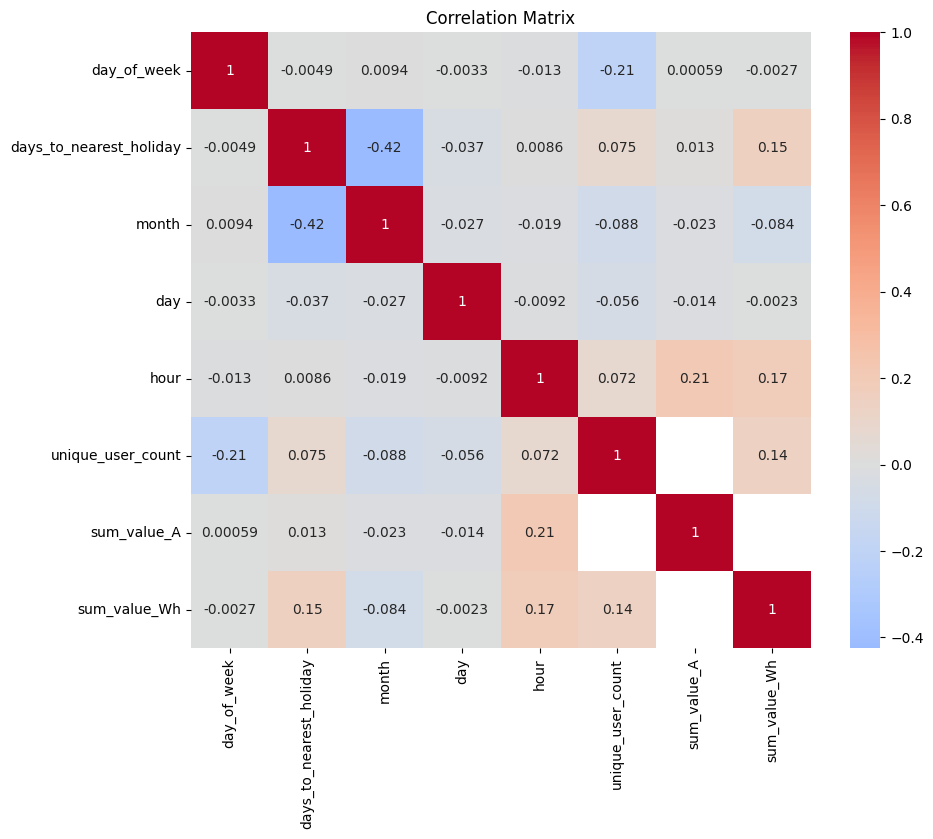


Summary Statistics:
        day_of_week  days_to_nearest_holiday         month           day  \
count  2.446083e+06             2.446083e+06  2.446083e+06  2.446083e+06   
mean   3.839819e+00             1.667868e+01  1.060123e+01  1.573719e+01   
std    1.996538e+00             1.286207e+01  1.113462e+00  8.730453e+00   
min    1.000000e+00             0.000000e+00  8.000000e+00  1.000000e+00   
25%    2.000000e+00             6.000000e+00  1.000000e+01  8.000000e+00   
50%    4.000000e+00             1.300000e+01  1.100000e+01  1.600000e+01   
75%    6.000000e+00             2.800000e+01  1.200000e+01  2.300000e+01   
max    7.000000e+00             4.300000e+01  1.200000e+01  3.100000e+01   

               hour  unique_user_count    sum_value_A  sum_value_Wh  
count  2.446083e+06       2.446083e+06  132140.000000   4688.000000  
mean   1.104646e+01       6.622727e+00      12.131254   6067.983788  
std    6.842034e+00       1.111422e+01      14.697249   8103.026492  
min    0.00000

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Data_sets/OCCP/df_logs_enriched_with_usage.pkl')

# Convert columns to numeric, handling errors
columns_to_analyze = [
    "day_of_week",
    "days_to_nearest_holiday",
    "month",
    "day",
    "hour",
    "unique_user_count",
    "sum_value_A",
    "sum_value_Wh"
]

# Create a clean dataframe for analysis
df_clean = df[columns_to_analyze].copy()

# Convert each column to numeric, handling errors
for col in columns_to_analyze:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

    # Print info about conversion
    print(f"\nColumn: {col}")
    print(f"Null values after conversion: {df_clean[col].isnull().sum()}")
    print(f"Sample unique values: {df_clean[col].dropna().sample(5).tolist()}")

# Calculate correlations for cleaned numeric columns
correlations = df_clean.corr()

# Create correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

# Basic summary statistics
print("\nSummary Statistics:")
print(df_clean.describe())

# Check for patterns across categorical variables
print("\nMean energy consumption (sum_value_Wh) by:")
print("\nDay of Week:")
print(df_clean.groupby('day_of_week')['sum_value_Wh'].mean().sort_values(ascending=False))

print("\nHour of Day:")
print(df_clean.groupby('hour')['sum_value_Wh'].mean().sort_values(ascending=False))

print("\nMonth:")
print(df_clean.groupby('month')['sum_value_Wh'].mean().sort_values(ascending=False))

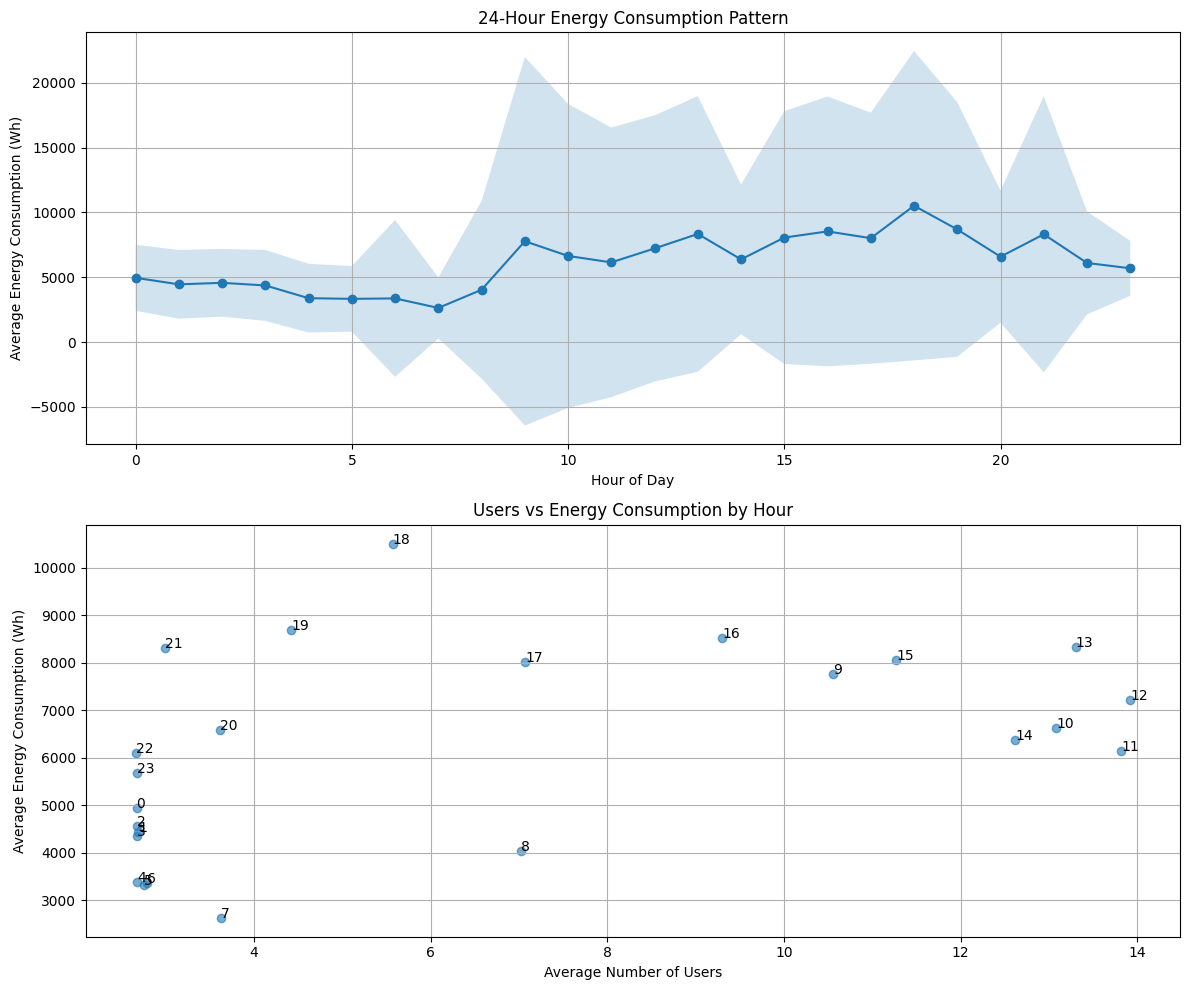


Peak Hours Analysis:
     sum_value_Wh                         unique_user_count
             mean  median       std count              mean
hour                                                       
18       10508.97  6656.0  11929.40   227              5.57
19        8679.18  6656.0   9818.45   200              4.42
16        8530.12  6656.0  10401.94   166              9.30
13        8333.93  6656.0  10628.55   179             13.30
21        8307.70  6656.0  10645.67   179              2.99

Peak vs Off-peak Analysis:
Average off-peak consumption (midnight-6am): 4056.51 Wh
Average peak consumption (4pm-7pm): 8931.10 Wh
Peak hours consume 2.2x more energy than off-peak hours


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load and clean data
df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Data_sets/OCCP/df_logs_enriched_with_usage.pkl')

# Convert columns to numeric
df['hour'] = pd.to_numeric(df['hour'], errors='coerce')
df['sum_value_Wh'] = pd.to_numeric(df['sum_value_Wh'], errors='coerce')
df['unique_user_count'] = pd.to_numeric(df['unique_user_count'], errors='coerce')

# Group by hour and calculate various statistics
hourly_stats = df.groupby('hour').agg({
    'sum_value_Wh': ['mean', 'median', 'std', 'count'],
    'unique_user_count': 'mean'
}).round(2)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: Energy consumption pattern
ax1.plot(hourly_stats[('sum_value_Wh', 'mean')], marker='o')
ax1.fill_between(range(24),
                 hourly_stats[('sum_value_Wh', 'mean')] - hourly_stats[('sum_value_Wh', 'std')],
                 hourly_stats[('sum_value_Wh', 'mean')] + hourly_stats[('sum_value_Wh', 'std')],
                 alpha=0.2)
ax1.set_title('24-Hour Energy Consumption Pattern')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Average Energy Consumption (Wh)')
ax1.grid(True)

# Plot 2: Users vs Energy
ax2.scatter(hourly_stats[('unique_user_count', 'mean')],
           hourly_stats[('sum_value_Wh', 'mean')],
           alpha=0.6)
# Add hour labels to each point
for i in range(24):
    ax2.annotate(str(i),
                (hourly_stats[('unique_user_count', 'mean')][i],
                 hourly_stats[('sum_value_Wh', 'mean')][i]))
ax2.set_title('Users vs Energy Consumption by Hour')
ax2.set_xlabel('Average Number of Users')
ax2.set_ylabel('Average Energy Consumption (Wh)')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print detailed statistics for peak hours
peak_hours = hourly_stats.nlargest(5, ('sum_value_Wh', 'mean'))
print("\nPeak Hours Analysis:")
print(peak_hours)

# Calculate relative increase during peak vs off-peak
off_peak_mean = hourly_stats.loc[0:6, ('sum_value_Wh', 'mean')].mean()
peak_mean = hourly_stats.loc[16:19, ('sum_value_Wh', 'mean')].mean()
increase_factor = peak_mean / off_peak_mean

print(f"\nPeak vs Off-peak Analysis:")
print(f"Average off-peak consumption (midnight-6am): {off_peak_mean:.2f} Wh")
print(f"Average peak consumption (4pm-7pm): {peak_mean:.2f} Wh")
print(f"Peak hours consume {increase_factor:.1f}x more energy than off-peak hours")

<ipython-input-48-ab924c812782>:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Commercial' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[mask, 'property_type'] = col.replace('prop_type_', '')


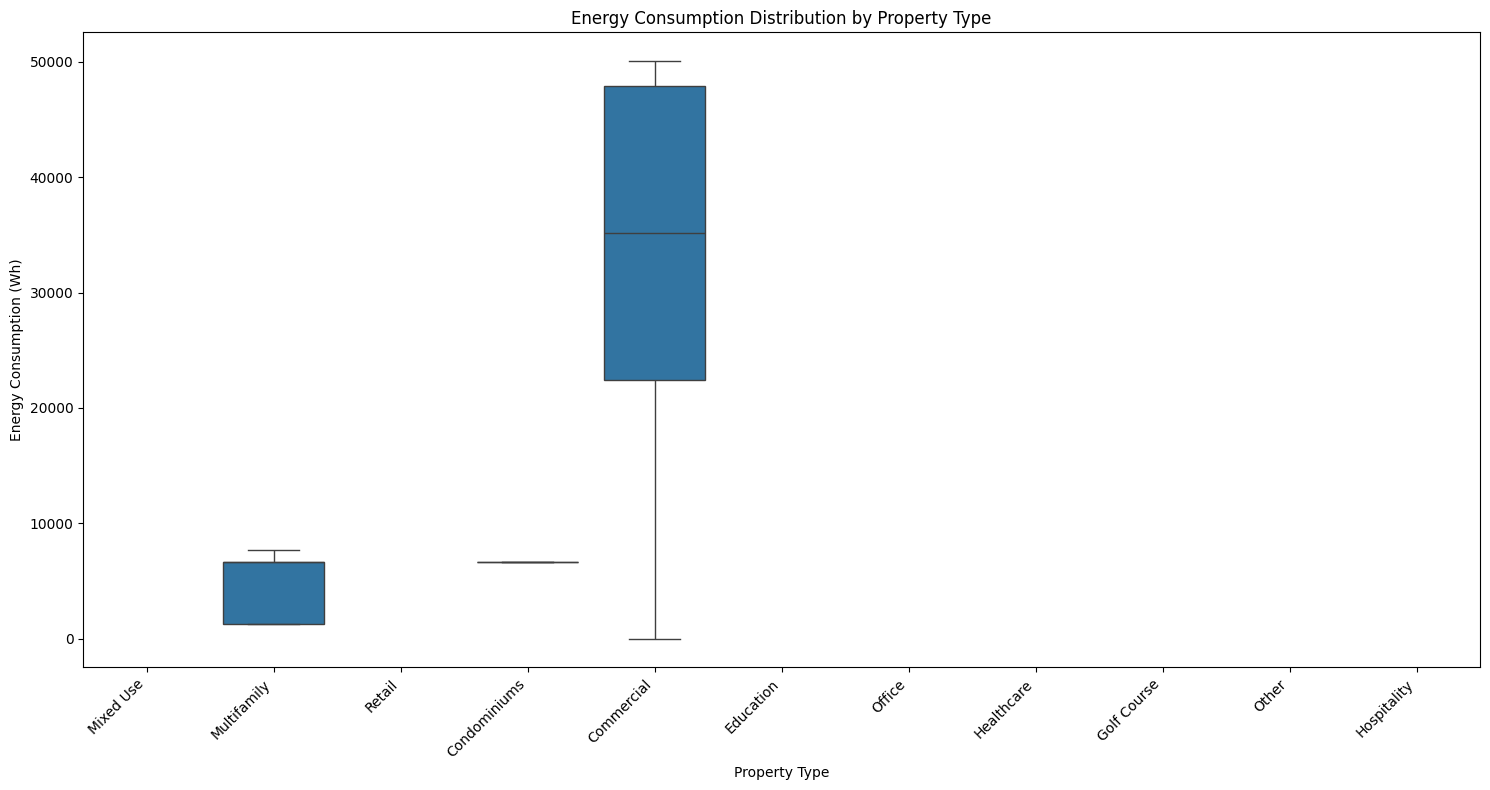


Basic statistics by property type:
                count          mean           std     min      25%      50%  \
property_type                                                                 
Commercial      268.0  34300.611940  13637.432999     0.0  22392.0  35150.0   
Condominiums     27.0   6656.000000      0.000000  6656.0   6656.0   6656.0   
Education         0.0           NaN           NaN     NaN      NaN      NaN   
Golf Course       0.0           NaN           NaN     NaN      NaN      NaN   
Healthcare        0.0           NaN           NaN     NaN      NaN      NaN   
Hospitality       0.0           NaN           NaN     NaN      NaN      NaN   
Mixed Use         0.0           NaN           NaN     NaN      NaN      NaN   
Multifamily    4393.0   4342.005919   2672.700562  1248.0   1248.0   6656.0   
Office            0.0           NaN           NaN     NaN      NaN      NaN   
Other             0.0           NaN           NaN     NaN      NaN      NaN   
Retail          

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Data_sets/OCCP/df_logs_enriched_with_usage.pkl')

# Convert sum_value_Wh to numeric
df['sum_value_Wh'] = pd.to_numeric(df['sum_value_Wh'], errors='coerce')

# Create a single property type column for easier plotting
prop_type_cols = [col for col in df.columns if col.startswith('prop_type_')]
df['property_type'] = np.nan

for col in prop_type_cols:
    mask = df[col] == 1
    df.loc[mask, 'property_type'] = col.replace('prop_type_', '')

# Create box plot
plt.figure(figsize=(15, 8))
sns.boxplot(x='property_type', y='sum_value_Wh', data=df)
plt.xticks(rotation=45, ha='right')
plt.title('Energy Consumption Distribution by Property Type')
plt.xlabel('Property Type')
plt.ylabel('Energy Consumption (Wh)')
plt.tight_layout()
plt.show()

# Print basic stats for each property type
print("\nBasic statistics by property type:")
stats = df.groupby('property_type')['sum_value_Wh'].describe()
print(stats)

# Count number of observations for each property type
print("\nNumber of observations per property type:")
counts = df['property_type'].value_counts()
print(counts)

<ipython-input-49-325fa31303fe>:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Commercial' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[mask, 'property_type'] = col.replace('prop_type_', '')
<ipython-input-49-325fa31303fe>:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
<ipython-input-49-325fa31303fe>:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')


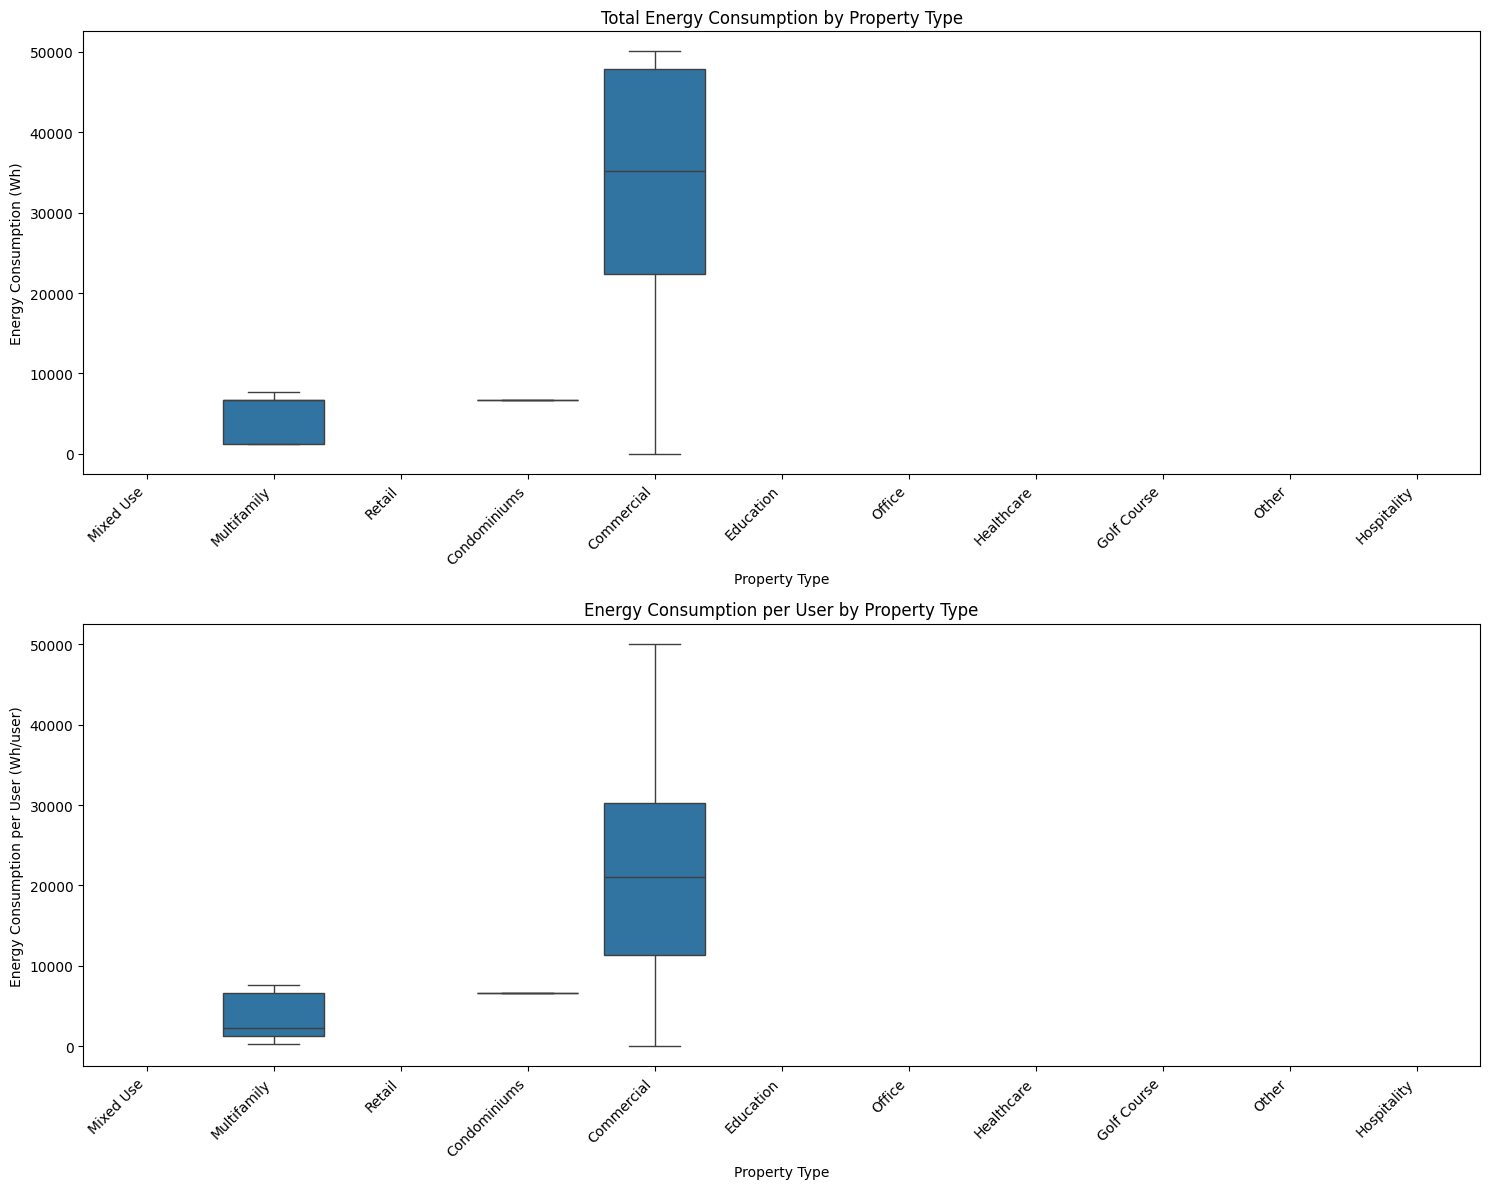


Statistics by property type:
              sum_value_Wh           unique_user_count energy_per_user
                     count      mean              mean            mean
property_type                                                         
Commercial             268  34300.61              1.90         22755.8
Condominiums            27   6656.00              2.76          6656.0
Education                0       NaN             29.95             NaN
Golf Course              0       NaN              1.95             NaN
Healthcare               0       NaN              5.96             NaN
Hospitality              0       NaN              1.00             NaN
Mixed Use                0       NaN              6.98             NaN
Multifamily           4393   4342.01              2.28          3878.3
Office                   0       NaN             15.67             NaN
Other                    0       NaN              3.78             NaN
Retail                   0       NaN           

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Data_sets/OCCP/df_logs_enriched_with_usage.pkl')

# Convert to numeric
df['sum_value_Wh'] = pd.to_numeric(df['sum_value_Wh'], errors='coerce')
df['unique_user_count'] = pd.to_numeric(df['unique_user_count'], errors='coerce')

# Create a single property type column
prop_type_cols = [col for col in df.columns if col.startswith('prop_type_')]
df['property_type'] = np.nan

for col in prop_type_cols:
    mask = df[col] == 1
    df.loc[mask, 'property_type'] = col.replace('prop_type_', '')

# Calculate energy per user
df['energy_per_user'] = df['sum_value_Wh'] / df['unique_user_count']

# Create two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Plot 1: Total Energy
sns.boxplot(x='property_type', y='sum_value_Wh', data=df, ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.set_title('Total Energy Consumption by Property Type')
ax1.set_xlabel('Property Type')
ax1.set_ylabel('Energy Consumption (Wh)')

# Plot 2: Energy per User
sns.boxplot(x='property_type', y='energy_per_user', data=df, ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.set_title('Energy Consumption per User by Property Type')
ax2.set_xlabel('Property Type')
ax2.set_ylabel('Energy Consumption per User (Wh/user)')

plt.tight_layout()
plt.show()

# Print statistics
print("\nStatistics by property type:")
stats = df.groupby('property_type').agg({
    'sum_value_Wh': ['count', 'mean'],
    'unique_user_count': 'mean',
    'energy_per_user': 'mean'
}).round(2)

print(stats)

In [ ]:
# First, let's look at the raw data before any processing
print("Original data counts by property type:")
for col in prop_type_cols:
    print(f"\n{col}:")
    print(f"Number of 1s: {df[col].sum()}")
    print(f"Number of non-null values: {df[col].count()}")

# Let's also check for nulls in key columns
print("\nNull values in key columns:")
print(df[['sum_value_Wh', 'unique_user_count']].isnull().sum())

# Let's look at the data before any type conversion
print("\nSample of raw data before conversion:")
sample_data = df[['property_type', 'sum_value_Wh', 'unique_user_count']].head(10)
print(sample_data)

# Check data types of key columns
print("\nData types of columns:")
print(df.dtypes)

Original data counts by property type:


NameError: name 'prop_type_cols' is not defined

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load your dataset
df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Data_sets/OCCP/df_logs_enriched_with_usage.pkl')

def clean_numeric_string(value):
    """Clean numeric string by taking the first valid number."""
    if pd.isna(value):
        return 0
    # Convert to string if not already
    value = str(value)
    # Find first number (integer or decimal)
    parts = value.split('.')
    if not parts:
        return 0
    try:
        # Take first valid number
        return float(parts[0])
    except ValueError:
        return 0

# Clean and convert sum_value columns
df['sum_value_A'] = df['sum_value_A'].apply(clean_numeric_string).astype(int)
df['sum_value_Wh'] = df['sum_value_Wh'].apply(clean_numeric_string).astype(int)
df['unique_user_count'] = df['unique_user_count'].astype(int)

# Select only numerical features for VIF calculation
numerical_columns = [
    "day_of_week",
    "day_weekend",
    "days_to_nearest_holiday",
    "year",
    "month",
    "day",
    "hour",
    "unique_user_count",
    "sum_value_A",
    "sum_value_Wh"
]

# Prepare the DataFrame for VIF calculation
X = df[numerical_columns].copy()

# Check for NaN and inf values
print(f"NaN values before VIF calculation: {X.isna().sum().sum()}")
print(f"Inf values before VIF calculation: {((X == np.inf) | (X == -np.inf)).sum().sum()}")

# Handle NaN and inf values
X = X.fillna(0)  # Replace NaN values with 0 or other strategy
X.replace([np.inf, -np.inf], 0, inplace=True)

# Check again after handling NaN and inf values
print(f"NaN values after VIF calculation: {X.isna().sum().sum()}")
print(f"Inf values after VIF calculation: {((X == np.inf) | (X == -np.inf)).sum().sum()}")

# Add a constant column for intercept
X['intercept'] = 1

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Drop the constant column after VIF calculation
vif_data = vif_data[vif_data["Feature"] != "intercept"]

# Display the VIF values
print(vif_data)

NaN values before VIF calculation: 0
Inf values before VIF calculation: 0
NaN values after VIF calculation: 0
Inf values after VIF calculation: 0


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


                   Feature       VIF
0              day_of_week  2.575743
1              day_weekend  2.581283
2  days_to_nearest_holiday  1.226261
3                     year  0.000000
4                    month  1.237284
5                      day  1.008361
6                     hour  1.038929
7        unique_user_count  1.100951
8              sum_value_A  1.402231
9             sum_value_Wh  1.424518


In [ ]:
# Drop suspect features and run VIF again

# Load the dataset
df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Data_sets/OCCP/df_logs_enriched_with_usage.pkl')

# Drop suspect features
df = df.drop(['day_weekend', 'year'], axis=1)

# Define numerical columns
numerical_columns = [
    "day_of_week",
    "days_to_nearest_holiday",
    "month",
    "day",
    "hour",
    "unique_user_count",
    "sum_value_A",
    "sum_value_Wh"
]

# Convert columns to numeric type and handle any non-numeric values
X = df[numerical_columns].copy()
for column in numerical_columns:
    # Convert to numeric, coerce any non-numeric values to NaN
    X[column] = pd.to_numeric(X[column], errors='coerce')

    # Fill NaN values with the median of the column
    X[column] = X[column].fillna(X[column].median())

# Add a constant column for intercept
X['intercept'] = 1

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Drop the constant column after VIF calculation
vif_data = vif_data[vif_data["Feature"] != "intercept"]

# Sort VIF values in descending order
vif_data = vif_data.sort_values('VIF', ascending=False)

# Display the VIF values
print("\nVariance Inflation Factors:")
print(vif_data)


Variance Inflation Factors:
                   Feature       VIF
2                    month  1.228764
1  days_to_nearest_holiday  1.225579
5        unique_user_count  1.069826
0              day_of_week  1.044732
6              sum_value_A  1.008886
4                     hour  1.007709
3                      day  1.007133
7             sum_value_Wh  1.000107


# Prep df for regression/ANOVA

In [ ]:
import pandas as pd
from scipy import stats
import numpy as np

# Load the dataset
df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Data_sets/OCCP/df_logs_enriched_with_usage.pkl')

# Define the dependent variable (y) - in this case let's use sum_value_Wh as our target
y = "sum_value_Wh"

# Define independent variables (features to compare groups)
independent_vars = [
    "day_of_week",
    "days_to_nearest_holiday",
    "month",
    "day",
    "hour",
    "unique_user_count"
    #"sum_value_A"
]

# Convert columns to numeric type and handle any non-numeric values
X = df[independent_vars].copy()
for column in independent_vars:
    X[column] = pd.to_numeric(X[column], errors='coerce')
    X[column] = X[column].fillna(X[column].median())

# Convert y to numeric
df[y] = pd.to_numeric(df[y], errors='coerce')
df[y] = df[y].fillna(df[y].median())

# Function to run one-way ANOVA for each independent variable against y
def run_anova_with_target(df, independent_vars, y):
    results = []

    for var in independent_vars:
        # Create groups based on the independent variable
        groups = []
        # Create 5 groups using quantiles for continuous variables
        df['group'] = pd.qcut(df[var], q=5, labels=['G1', 'G2', 'G3', 'G4', 'G5'])

        # Get the y values for each group
        for group in df['group'].unique():
            groups.append(df[df['group'] == group][y].values)

        # Perform one-way ANOVA
        f_stat, p_val = stats.f_oneway(*groups)

        results.append({
            'Independent Variable': var,
            'F-statistic': f_stat,
            'p-value': p_val
        })

    return pd.DataFrame(results)

# Run ANOVA
anova_results = run_anova_with_target(df, independent_vars, y)

# Sort results by p-value
anova_results_sorted = anova_results.sort_values('p-value')

# Display results
pd.set_option('display.float_format', lambda x: '{:.10f}'.format(x) if x < 0.0001 else '{:.4f}'.format(x))
print(f"\nOne-way ANOVA Results (dependent variable: {y}):")
print(anova_results_sorted)

# Add significance indicators
anova_results_sorted['Significance'] = ['***' if p < 0.001
                                      else '**' if p < 0.01
                                      else '*' if p < 0.05
                                      else 'ns' for p in anova_results_sorted['p-value']]

print("\nSignificance levels:")
print("***: p < 0.001")
print("**: p < 0.01")
print("*: p < 0.05")
print("ns: not significant")

ValueError: Bin edges must be unique: Index([8.0, 9.0, 10.0, 11.0, 12.0, 12.0], dtype='float64', name='month').
You can drop duplicate edges by setting the 'duplicates' kwarg

In [ ]:
import numpy as np
# Fit a regression model
X = sm.add_constant(df_sampled['unique_user_count'])  # Add intercept
model = sm.OLS(df_sampled['hour_sum_value_A'], X).fit()

# Predict values for regression line
predictions = model.predict(X)

# Plot scatter with regression line
plt.figure(figsize=(8, 6))
plt.scatter(df_sampled['unique_user_count'], df_sampled['hour_sum_value_A'], alpha=0.6, label='Data Points')
plt.plot(df_sampled['unique_user_count'], predictions, color='red', label='Regression Line')
plt.title('Regression Plot: Unique User Count vs Hour Sum Value 0')
plt.xlabel('Unique User Count')
plt.ylabel('Hour hour_sum_value_A')
plt.legend()
plt.show()


# Ensure property_id is treated as a categorical variable
df_sampled['property_id'] = df_sampled['property_id'].astype('category')

# Prepare the formula for ANOVA
independent_vars = ['unique_user_count', 'property_id'] + [col for col in df_sampled.columns if col.startswith('day_')]
formula = 'hour_sum_value_A ~ ' + ' + '.join(independent_vars)

# Fit the model
model = ols(formula, data=df_sampled).fit()

# Perform ANOVA
anova_results = sm.stats.anova_lm(model, typ=2)

# Display the ANOVA results
print(anova_results)


In [ ]:
# Calculate the IQR for the column with potential outliers
Q1 = df_sampled['hour_sum_value_A'].quantile(0.25)
Q3 = df_sampled['hour_sum_value_A'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
df_filtered = df_sampled[(df_sampled['hour_sum_value_A'] >= lower_bound) & (df_sampled['hour_sum_value_A'] <= upper_bound)]


In [ ]:
## Create a property lookup

import os
import logging
import psycopg2
import pandas as pd

# Configure logging
logging.basicConfig(level=logging.INFO)

# Load credentials from file
def load_credentials(path_to_credentials):
    try:
        with open(path_to_credentials, 'r') as file:
            for line_num, line in enumerate(file, start=1):
                line = line.strip()
                if line and '=' in line:
                    key, value = line.split('=', 1)  # Split only on the first '='
                    os.environ[key.strip()] = value.strip()
                else:
                    logging.warning(f"Issue with line {line_num} in {path_to_credentials}: '{line}'")
        logging.info("Credentials loaded successfully.")
    except Exception as e:
        logging.error(f"Error loading credentials: {str(e)}")

# Call the function to load credentials
path_to_credentials = '/content/drive/MyDrive/Colab Notebooks/credentials/aws_credentials.txt'
load_credentials(path_to_credentials)

# Create connection parameters from environment variables
connection_params = {
    'host': os.getenv('DB_HOST'),
    'dbname': os.getenv('DB_NAME'),
    'user': os.getenv('DB_USER'),
    'password': os.getenv('DB_PASSWORD'),
    'port': os.getenv('DB_PORT')  # Fetch the port from environment variables
}

# Function to fetch non-transposed data
def fetch_non_transposed_data(cursor, table):
    query = f"SELECT * FROM {table};"
    cursor.execute(query)
    rows = cursor.fetchall()
    column_names = [desc[0] for desc in cursor.description]

    # Create a DataFrame from the fetched data
    df = pd.DataFrame(rows, columns=column_names)
    return df

# List of tables to process
tables = [
    "location",
    "properties"
]

# Connect to the PostgreSQL database
try:
    connection = psycopg2.connect(**connection_params)
    cursor = connection.cursor()

    # Loop through each table name
    for table in tables:
        logging.info(f"Processing table: {table}")

        # Fetch non-transposed data
        df_non_transposed = fetch_non_transposed_data(cursor, table)

        # Write the DataFrame to CSV with new naming convention
        output_csv_path = f'/content/drive/MyDrive/Colab Notebooks/Data_sets/Chargie/{table}_table_extract.csv'
        df_non_transposed.to_csv(output_csv_path, index=False)
        logging.info(f"Data written to {output_csv_path} successfully.")

except Exception as error:
    logging.error(f"Error connecting to the database: {error}")

finally:
    if 'connection' in locals() and connection:
        cursor.close()
        connection.close()
        logging.info("Connection closed.")



In [ ]:
import numpy as np
# Fit a regression model
X = sm.add_constant(df_sampled['unique_user_count'])  # Add intercept
model = sm.OLS(df_sampled['hour_sum_value_A'], X).fit()

# Predict values for regression line
predictions = model.predict(X)

# Plot scatter with regression line
plt.figure(figsize=(8, 6))
plt.scatter(df_filtered['unique_user_count'], df_filtered['hour_sum_value_A'], alpha=0.6, label='Data Points')
plt.plot(df_filtered['unique_user_count'], predictions, color='red', label='Regression Line')
plt.title('Regression Plot: Unique User Count vs Hour Sum Value 0')
plt.xlabel('Unique User Count')
plt.ylabel('Hour hour_sum_value_A')
plt.legend()
plt.show()


# Ensure property_id is treated as a categorical variable
df_filtered['property_id'] = df_filtered['property_id'].astype('category')

# Prepare the formula for ANOVA
independent_vars = ['unique_user_count', 'property_id'] + [col for col in df_filtered.columns if col.startswith('day_')]
formula = 'hour_sum_value_A ~ ' + ' + '.join(independent_vars)

# Fit the model
model = ols(formula, data=df_filtered).fit()

# Perform ANOVA
anova_results = sm.stats.anova_lm(model, typ=2)

# Display the ANOVA results
print(anova_results)

In [ ]:
# Decorate data with engineered values

from datetime import datetime
import pytz

# Function to convert to PST and extract datetime
def convert_to_pst_as_datetime(timestamp):
    # Parse the UTC timestamp
    utc_time = datetime.strptime(timestamp, "%Y-%m-%dT%H:%M:%S.%fZ")
    # Set timezone to UTC
    utc_time = utc_time.replace(tzinfo=pytz.UTC)
    # Convert to PST
    pst_time = utc_time.astimezone(pytz.timezone('US/Pacific'))
    # Truncate to day, month, year, and hour (zero minutes and seconds)
    return pst_time.replace(minute=0, second=0, microsecond=0)

# Apply the function to convert timestamp
df_a_s_o['time_sample'] = df_a_s_o['timestamp'].apply(convert_to_pst_as_datetime)

# Add a column for day of the week (0 = Monday, 6 = Sunday)
df_a_s_o['day_of_week'] = df_a_s_o['time_sample'].dt.dayofweek

# Add a column for hour of the day (24hr format)
df_a_s_o['hour_of_day'] = df_a_s_o['time_sample'].dt.hour

# Add a column for ISO week number
df_a_s_o['week_number'] = df_a_s_o['time_sample'].dt.isocalendar().week

# Add in count of unique users
df_a_s_o['unique_user_count'] = (
    df_a_s_o
    .groupby(['week_number', 'day_of_week', 'hour_of_day'])['user_id']
    .transform('nunique')
)

# Add in sum of unit_a
df_a_s_o['sum_of_unit_a'] = (
    df_a_s_o
    .groupby(['week_number', 'day_of_week', 'hour_of_day'])['unit_a']
    .transform('sum')
)

# Add in sum of watt_h
df_a_s_o['sum_of_unit_wh'] = (
    df_a_s_o
    .groupby(['week_number', 'day_of_week', 'hour_of_day'])['unit_wh']
    .transform('sum')
)

# Print the updated DataFrame
print(df_a_s_o)

In [ ]:
# Data Check
print(df_a_s_o['week_number'].unique())


# Calculate the overall count of unique user IDs
unique_user_count = df_a_s_o['user_id'].nunique()

# Calculate the sum of unit_a
sum_of_unit_a = df_a_s_o['unit_a'].sum()

# Calculate the sum of watt_h
sum_of_unit_wh = df_a_s_o['unit_wh'].sum()

# Print the results
print(f"Unique User Count: {unique_user_count}")
print(f"Sum of unit_a: {sum_of_unit_a}")
print(f"Sum of unit_wh: {sum_of_unit_wh}")

# Unique User Count: 1028
# Sum of unit_a: 84714332.39000002
# Sum of unit_wh: 57182938816884.78

In [ ]:
df_a_s_o.info()

In [ ]:
# Reduce the DataFrame to unique rows based on the specified columns
reduced_df = df_a_s_o.drop_duplicates(
    subset=['day_of_week', 'hour_of_day', 'week_number', 'unique_user_count', 'sum_of_unit_a', 'sum_of_unit_wh']
)

# Keep only the specified columns
reduced_df = reduced_df[['day_of_week', 'hour_of_day', 'week_number', 'unique_user_count', 'sum_of_unit_a', 'sum_of_unit_wh']]

# Display the resulting DataFrame
print(reduced_df.info())
print(reduced_df.head())


In [ ]:

# Calculate the sum of unit_a
sum_of_unit_a = reduced_df['sum_of_unit_a'].sum()

# Calculate the sum of watt_h
sum_of_unit_wh = reduced_df['sum_of_unit_wh'].sum()

# Print the results

print(f"Sum of unit_a: {sum_of_unit_a}")
print(f"Sum of unit_wh: {sum_of_unit_wh}")

# Unique User Count: 1028
# Sum of unit_a: 84714332.39000002
# Sum of unit_wh: 57182938816884.78



In [ ]:
# Write a local file to take a look

df_a_s_o.to_csv('/content/drive/MyDrive/Colab Notebooks/Data_sets/Chargie/df_a_s_o.csv', index=False)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.regplot(x='unique_user_count', y='sum_of_unit_wh', data=df_a_s_o, scatter_kws={'alpha': 0.3}, line_kws={'color': 'red'})
plt.xlabel('User unique_user_count Count')
plt.ylabel('Total Unit WH')
plt.title('Regression Plot: User ID Count vs. Total Unit WH')
plt.show()

In [ ]:
df_a_s_o.info()

In [ ]:
# Data is week 32 through week 44 (12)
# So below, there is no week lag1 value for week 32 because it is the first

# Identify the peak total_unit_wh for each week
peak_weekly_data = df.loc[df.groupby('week_number')['sum_of_unit_wh'].idxmax()]

# Sort by week number to ensure correct lagging
peak_weekly_data = peak_weekly_data.sort_values('week_number')

# Add only lag_1 features
peak_weekly_data['lag_1_day_of_week'] = peak_weekly_data['day_of_week'].shift(1)
peak_weekly_data['lag_1_hour'] = peak_weekly_data['hour_of_day'].shift(1)

# Drop rows with insufficient lag (week 1)
peak_weekly_data = peak_weekly_data.dropna()

# Retain only relevant columns
peak_weekly_data = peak_weekly_data[['week_number', 'day_of_week', 'hour_of_day', 'lag_1_day_of_week', 'lag_1_hour']]

print("Updated DataFrame:")
print(peak_weekly_data)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Features (lagged day of week and hour) and target (day of week)
X = peak_weekly_data[['lag_1_day_of_week', 'lag_1_hour']]
y = peak_weekly_data['day_of_week']  # Target: Day of the week

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Day of Week Prediction Accuracy:", accuracy)

# Display true vs predicted values
results = pd.DataFrame({'True Day': y_test, 'Predicted Day': y_pred})
print("\nTrue vs Predicted Days of the Week:")
print(results)


In [ ]:


# Feature importance for day_of_week classification
clf_importances = clf.feature_importances_
plt.barh(X.columns, clf_importances)
plt.title("Feature Importance for Day of Week Prediction")
plt.show()

# Feature importance for hour regression
reg_importances = reg.feature_importances_
plt.barh(X.columns, reg_importances)
plt.title("Feature Importance for Hour Prediction")
plt.show()


### Data Exploration

## Appendix

####AWS Tables

In [ ]:

# Load credentials from file
def load_credentials(path_to_credentials):
    try:
        with open(path_to_credentials, 'r') as file:
            for line_num, line in enumerate(file, start=1):
                line = line.strip()
                if line and '=' in line:
                    key, value = line.split('=', 1)  # Split only on the first '='
                    os.environ[key.strip()] = value.strip()
                else:
                    logging.warning(f"Issue with line {line_num} in {path_to_credentials}: '{line}'")
        logging.info("Credentials loaded successfully.")
    except Exception as e:
        logging.error(f"Error loading credentials: {str(e)}")

# Call the function to load credentials
path_to_credentials = '/content/drive/MyDrive/Colab Notebooks/credentials/aws_credentials.txt'
load_credentials(path_to_credentials)

# Create connection parameters from environment variables
connection_params = {
    'host': os.getenv('DB_HOST'),
    'dbname': os.getenv('DB_NAME'),
    'user': os.getenv('DB_USER'),
    'password': os.getenv('DB_PASSWORD'),
    'port': os.getenv('DB_PORT')  # Fetch the port from environment variables
}

# Connect to the PostgreSQL database
try:
    connection = psycopg2.connect(**connection_params)
    cursor = connection.cursor()

    # Execute a query to fetch all table names
    query = """
    SELECT table_name
    FROM information_schema.tables
    WHERE table_schema = 'public';
    """

    cursor.execute(query)
    tables = cursor.fetchall()

    # Print the table names
    for table in tables:
        print(table[0])

except Exception as error:
    print(f"Error connecting to the database: {error}")

finally:
    if 'connection' in locals() and connection:
        cursor.close()
        connection.close()
        print("Connection closed.")


In [ ]:
# This creates a table of field names and sample values
import os
import logging
import psycopg2
import pandas as pd

# Configure logging
logging.basicConfig(level=logging.INFO)

# Load credentials from file
def load_credentials(path_to_credentials):
    try:
        with open(path_to_credentials, 'r') as file:
            for line_num, line in enumerate(file, start=1):
                line = line.strip()
                if line and '=' in line:
                    key, value = line.split('=', 1)  # Split only on the first '='
                    os.environ[key.strip()] = value.strip()
                else:
                    logging.warning(f"Issue with line {line_num} in {path_to_credentials}: '{line}'")
        logging.info("Credentials loaded successfully.")
    except Exception as e:
        logging.error(f"Error loading credentials: {str(e)}")

# Call the function to load credentials
path_to_credentials = '/content/drive/MyDrive/Colab Notebooks/credentials/aws_credentials.txt'
load_credentials(path_to_credentials)

# Create connection parameters from environment variables
connection_params = {
    'host': os.getenv('DB_HOST'),
    'dbname': os.getenv('DB_NAME'),
    'user': os.getenv('DB_USER'),
    'password': os.getenv('DB_PASSWORD'),
    'port': os.getenv('DB_PORT')  # Fetch the port from environment variables
}

# List of tables to process
tables = [
    "group_discount_properties", "adjustment", "payment", "group_discount",
    "roles", "pos_device", "location", "station_credit_program", "station_history",
    "subscription", "user_discount_properties", "users", "router", "vehicle",
    "properties", "rfid_user", "stripe_payment_intent", "adr", "audit",
    "cluster_name", "global_setting", "station_logs", "station_model",
    "awsdms_ddl_audit", "user_access", "pricing", "stations", "gateway",
    "gateway_ip_lease", "errors", "credit_program", "maintenance_window",
    "refresh_token", "net_device_ip_lease", "ocpp_sub_session", "property_types",
    "user_device", "transaction", "address", "accounts", "net_devices",
    "organizations", "ocpp_session", "panels", "flyway_schema_history",
    "connectors", "clusters"
]


# "station_logs" is the big one. WOuld have the same fields/data as MeterValues data in Splunk.




# Connect to the PostgreSQL database
try:
    connection = psycopg2.connect(**connection_params)
    cursor = connection.cursor()

    # Loop through each table name
    for table in tables:
        logging.info(f"Processing table: {table}")

        # Query to fetch the first few rows from the current table
        query = f"SELECT * FROM {table} LIMIT 10;"
        cursor.execute(query)

        # Fetch the rows
        rows = cursor.fetchall()
        # Fetch the column headers
        column_names = [desc[0] for desc in cursor.description]

        # Create a DataFrame from the fetched data
        df = pd.DataFrame(rows, columns=column_names)

        # Prepare the transposed DataFrame
        transposed_data = {
            'Header': column_names,
            'Data Type': [df[col].dtype.name for col in column_names],  # Get the data type
            'Example': [df[col].iloc[0] if not df[col].empty else None for col in column_names]  # Example from the first row
        }

        df_transposed = pd.DataFrame(transposed_data)

        # Write the DataFrame to CSV
        output_csv_path = f'/content/drive/MyDrive/Colab Notebooks/Data_sets/OCCP/{table}_fields.csv'
        df_transposed.to_csv(output_csv_path, index=False)
        logging.info(f"Data written to {output_csv_path} successfully.")

except Exception as error:
    logging.error(f"Error connecting to the database: {error}")

finally:
    if 'connection' in locals() and connection:
        cursor.close()
        connection.close()
        logging.info("Connection closed.")

In [ ]:
# This creates a table of sample records

import os
import logging
import psycopg2
import pandas as pd

# Configure logging
logging.basicConfig(level=logging.INFO)

# Load credentials from file
def load_credentials(path_to_credentials):
    try:
        with open(path_to_credentials, 'r') as file:
            for line_num, line in enumerate(file, start=1):
                line = line.strip()
                if line and '=' in line:
                    key, value = line.split('=', 1)  # Split only on the first '='
                    os.environ[key.strip()] = value.strip()
                else:
                    logging.warning(f"Issue with line {line_num} in {path_to_credentials}: '{line}'")
        logging.info("Credentials loaded successfully.")
    except Exception as e:
        logging.error(f"Error loading credentials: {str(e)}")

# Call the function to load credentials
path_to_credentials = '/content/drive/MyDrive/Colab Notebooks/credentials/aws_credentials.txt'
load_credentials(path_to_credentials)

# Create connection parameters from environment variables
connection_params = {
    'host': os.getenv('DB_HOST'),
    'dbname': os.getenv('DB_NAME'),
    'user': os.getenv('DB_USER'),
    'password': os.getenv('DB_PASSWORD'),
    'port': os.getenv('DB_PORT')  # Fetch the port from environment variables
}

# Function to fetch non-transposed data
def fetch_non_transposed_data(cursor, table):
    query = f"SELECT * FROM {table} LIMIT 10;"
    cursor.execute(query)
    rows = cursor.fetchall()
    column_names = [desc[0] for desc in cursor.description]

    # Create a DataFrame from the fetched data
    df = pd.DataFrame(rows, columns=column_names)
    return df

# List of tables to process
tables = [
    "group_discount_properties", "adjustment", "payment", "group_discount",
    "roles", "pos_device", "location", "station_credit_program", "station_history",
    "subscription", "user_discount_properties", "users", "router", "vehicle",
    "properties", "rfid_user", "stripe_payment_intent", "adr", "audit",
    "cluster_name", "global_setting", "station_logs", "station_model",
    "awsdms_ddl_audit", "user_access", "pricing", "stations", "gateway",
    "gateway_ip_lease", "errors", "credit_program", "maintenance_window",
    "refresh_token", "net_device_ip_lease", "ocpp_sub_session", "property_types",
    "user_device", "transaction", "address", "accounts", "net_devices",
    "organizations", "ocpp_session", "panels", "flyway_schema_history",
    "connectors", "clusters"
]

# Connect to the PostgreSQL database
try:
    connection = psycopg2.connect(**connection_params)
    cursor = connection.cursor()

    # Loop through each table name
    for table in tables:
        logging.info(f"Processing table: {table}")

        # Fetch non-transposed data
        df_non_transposed = fetch_non_transposed_data(cursor, table)

        # Write the DataFrame to CSV with new naming convention
        output_csv_path = f'/content/drive/MyDrive/Colab Notebooks/Data_sets/OCCP/{table}_example_data.csv'
        df_non_transposed.to_csv(output_csv_path, index=False)
        logging.info(f"Data written to {output_csv_path} successfully.")

except Exception as error:
    logging.error(f"Error connecting to the database: {error}")

finally:
    if 'connection' in locals() and connection:
        cursor.close()
        connection.close()
        logging.info("Connection closed.")


###Create a table for all property info

In [ ]:
import pandas as pd
import os

# File paths
properties_file = '/content/drive/MyDrive/Colab Notebooks/Data_sets/OCCP/properties.csv'
property_types_file = '/content/drive/MyDrive/Colab Notebooks/Data_sets/OCCP/property_types.csv'
output_file = '/content/drive/MyDrive/Colab Notebooks/Data_sets/OCCP/property_lookup_2.csv'

# Load and verify files
if not os.path.exists(properties_file):
    raise FileNotFoundError(f"File not found: {properties_file}")
if not os.path.exists(property_types_file):
    raise FileNotFoundError(f"File not found: {property_types_file}")

properties = pd.read_csv(properties_file)
property_types = pd.read_csv(property_types_file)

# Normalize column names to lowercase and strip whitespace
properties.columns = properties.columns.str.strip().str.lower()
property_types.columns = property_types.columns.str.strip().str.lower()

# Perform the left join with suffixes
property_lookup = properties.merge(
    property_types,
    how='left',  # Use 'left' join to keep all rows from properties and add property_type name where available
    left_on='property_type',  # Assuming 'property_type' is the column in properties.csv
    right_on='id',  # Assuming 'id' is the column in property_types.csv
    suffixes=('_property', '_type')
)

# Keep all columns from properties and just add the 'name_type' column as 'property_type'
property_lookup['property_type'] = property_lookup['name_type']

# Drop the 'name_type' column, since we already added it as 'property_type'
property_lookup = property_lookup.drop(columns=['name_type'])

# Rename 'id_property' column to 'property_id'
property_lookup = property_lookup.rename(columns={'id_property': 'property_id'})

# Save the resulting DataFrame to CSV
property_lookup.to_csv(output_file, index=False)
print(f"Property lookup table saved to {output_file}")


# Now I need to build the correct table directly from RS

In [ ]:
import os
import pandas as pd
import logging
from itertools import combinations

# Configure logging
logging.basicConfig(level=logging.INFO)

# Path to the directory containing the CSV files
data_dir = '/content/drive/MyDrive/Colab Notebooks/Data_sets/Chargie/'

# List of tables (as per your previous code)
tables = [
    "group_discount_properties", "adjustment", "payment", "group_discount",
    "roles", "pos_device", "location", "station_credit_program", "station_history",
    "subscription", "user_discount_properties", "users", "router", "vehicle",
    "properties", "rfid_user", "stripe_payment_intent", "adr", "audit",
    "cluster_name", "global_setting", "station_logs", "station_model",
    "awsdms_ddl_audit", "user_access", "pricing", "stations", "gateway",
    "gateway_ip_lease", "errors", "credit_program", "maintenance_window",
    "refresh_token", "net_device_ip_lease", "ocpp_sub_session", "property_types",
    "user_device", "transaction", "address", "accounts", "net_devices",
    "organizations", "ocpp_session", "panels", "flyway_schema_history",
    "connectors", "clusters"
]

# Function to load CSV files into DataFrames
def load_dataframes(tables):
    dataframes = {}
    for table in tables:
        csv_path = os.path.join(data_dir, f"{table}_example_data.csv")
        try:
            df = pd.read_csv(csv_path)
            dataframes[table] = df
            logging.info(f"Loaded data for table: {table}")
        except Exception as e:
            logging.error(f"Error loading data for table {table}: {e}")
    return dataframes

# Function to find strict join matches
def find_strict_joins(df1, df2, table1_name, table2_name):
    strict_joins = []
    # Iterate over all column pairs
    for col1 in df1.columns:
        for col2 in df2.columns:
            if df1[col1].dtype == df2[col2].dtype:
                # Perform the join
                joined_df = pd.merge(df1, df2, left_on=col1, right_on=col2, how='inner')
                # Check if all rows in df1 are in the joined DataFrame
                if len(joined_df) == len(df1):
                    strict_joins.append((col1, col2))
                    logging.info(f"Strict join success: {table1_name}.{col1} <-> {table2_name}.{col2}")
    return strict_joins

# Main function to perform the strict join analysis
def analyze_strict_joins(tables):
    dataframes = load_dataframes(tables)
    results = {}
    table_pairs = combinations(tables, 2)

    for table1, table2 in table_pairs:
        df1 = dataframes.get(table1)
        df2 = dataframes.get(table2)

        if df1 is not None and df2 is not None:
            logging.info(f"Analyzing strict joins between {table1} and {table2}")
            joins = find_strict_joins(df1, df2, table1, table2)
            if joins:
                results[f"{table1} <-> {table2}"] = joins
        else:
            logging.warning(f"Data for {table1} or {table2} is missing. Skipping.")

    return results

# Run the strict join analysis
strict_join_results = analyze_strict_joins(tables)

# Print the results
for table_pair, joins in strict_join_results.items():
    print(f"\nStrict joins for {table_pair}:")
    for col1, col2 in joins:
        print(f"Columns: {table_pair.split(' <-> ')[0]}.{col1} <-> {table_pair.split(' <-> ')[1]}.{col2}")

if not strict_join_results:
    print("No strict joins found.")


In [ ]:
import os
import logging
import pandas as pd
from sqlalchemy import create_engine

# Configure logging
logging.basicConfig(level=logging.INFO)

# Load credentials from file
def load_credentials(path_to_credentials):
    try:
        with open(path_to_credentials, 'r') as file:
            for line_num, line in enumerate(file, start=1):
                line = line.strip()
                if line and '=' in line:
                    key, value = line.split('=', 1)  # Split only on the first '='
                    os.environ[key.strip()] = value.strip()
                else:
                    logging.warning(f"Issue with line {line_num} in {path_to_credentials}: '{line}'")
        logging.info("Credentials loaded successfully.")
    except Exception as e:
        logging.error(f"Error loading credentials: {str(e)}")

# Call the function to load credentials
path_to_credentials = '/content/drive/MyDrive/Colab Notebooks/credentials/aws_credentials.txt'
load_credentials(path_to_credentials)

# Create connection string for SQLAlchemy
connection_string = f"postgresql+psycopg2://{os.getenv('DB_USER')}:{os.getenv('DB_PASSWORD')}@{os.getenv('DB_HOST')}:{os.getenv('DB_PORT')}/{os.getenv('DB_NAME')}"
engine = create_engine(connection_string)

# Function to fetch column names for a table
def get_columns(table_name):
    try:
        query = f"""
        SELECT column_name, data_type
        FROM information_schema.columns
        WHERE table_name = '{table_name}';
        """
        with engine.connect() as connection:
            df = pd.read_sql_query(query, connection)
        return df[['column_name', 'data_type']].to_dict('records')
    except Exception as e:
        logging.error(f"Error fetching columns for table {table_name}: {e}")
        return []

# Function to test join logic between two tables
def test_joins(table1, table2, attempts=3):
    columns_table1 = get_columns(table1)
    columns_table2 = get_columns(table2)
    successful_joins = []

    for col1 in columns_table1:
        for col2 in columns_table2:
            # Only test joins on matching data types
            if col1['data_type'] == col2['data_type']:
                success_count = 0
                for _ in range(attempts):  # Attempt the join multiple times
                    query = f"""
                    SELECT *
                    FROM {table1} t1
                    INNER JOIN {table2} t2
                    ON t1.{col1['column_name']} = t2.{col2['column_name']}
                    LIMIT 1;  -- Test with one row at a time
                    """
                    try:
                        with engine.connect() as connection:
                            df = pd.read_sql_query(query, connection)
                            if not df.empty:
                                success_count += 1
                    except Exception as e:
                        logging.debug(f"Join failed for {table1}.{col1['column_name']} = {table2}.{col2['column_name']}: {e}")

                if success_count == attempts:  # Only count as successful if all attempts work
                    successful_joins.append((col1['column_name'], col2['column_name']))
                    logging.info(f"Successful join: {table1}.{col1['column_name']} = {table2}.{col2['column_name']}")

    return successful_joins

# Cross-check join fields for all table pairs
tables = [
    "users", "ocpp_sub_session"
]

results = {}

for i, table1 in enumerate(tables):
    for table2 in tables[i+1:]:
        logging.info(f"Testing joins between {table1} and {table2}")
        joins = test_joins(table1, table2)
        if joins:
            results[f"{table1} <-> {table2}"] = joins
        else:
            logging.info(f"No join found between {table1} and {table2}")

# Print results
for table_pair, joins in results.items():
    print(f"Successful joins for {table_pair}: {joins}")

if not results:
    print("No successful joins found.")


In [ ]:
import pandas as pd
import json

# Example dataframe (assuming df['message'] contains the raw strings)
# Clean the 'message' column by removing the prefix 'OCPP : MeterValues '
def clean_message(msg):
    try:
        # Remove the prefix
        msg_cleaned = msg.lstrip('OCPP : MeterValues ')

        # Attempt to load the cleaned message as JSON
        return json.loads(msg_cleaned)
    except (json.JSONDecodeError, TypeError):
        # If the message cannot be decoded as JSON, return None or handle as needed
        return None

# Apply the function to the 'message' column
df['message'] = df['message'].apply(clean_message)

# Filter out rows where the 'message' column is None (indicating a JSON parse failure)
df = df[df['message'].notna()]

# Step 1: Extract top-level fields and keep 'meterValue' as is (as a list of dicts)
flattened_rows = []

for idx, row in df.iterrows():
    message = row['message']  # Now this is a valid JSON object

    # Extract top-level fields
    connector_id = message.get('connectorId')
    transaction_id = message.get('transactionId')

    # Keep the 'meterValue' field as is (as a list of dicts)
    meter_value = message.get('meterValue', [])

    # Add a row to the flattened list, including the nested 'meterValue' list
    flattened_rows.append({
        '_time': row['time'],  # Retain the original timestamp from the dataframe
        'user_id': row['user_id'],  # Assuming 'user_id' is part of the original dataframe
        'connectorId': connector_id,
        'meterValue': meter_value  # The entire 'meterValue' field, as it is (list of dictionaries)
    })

# Step 2: Create a new DataFrame from the flattened rows
flattened_df = pd.DataFrame(flattened_rows)

# Display the resulting DataFrame
print(flattened_df.head())


In [ ]:
import pandas as pd

# Set pandas options to display the full content of any column (e.g., 'meterValue')
pd.set_option('display.max_colwidth', None)

# Now, display the full content of the 'meterValue' column for the first 5 rows
print(flattened_df['meterValue'].head(1))

In [ ]:
import pandas as pd

# Create a list to hold the expanded rows
expanded_rows = []

# Iterate over each row in the dataframe
for idx, row in flattened_df.iterrows():
    meter_values = row['meterValue']  # This is the list of meter readings (list of dicts)

    # For each meter value entry (there should be one timestamp and a list of measurements)
    for meter in meter_values:
        timestamp = meter['timestamp']  # Extract the timestamp

        # Initialize values for each measurement type
        watt_hours_value = None  # WattHours
        amps_value = None        # Amps (Current)
        voltage_value = None     # Voltage (Volts)

        # Iterate over the sampledValue list (which contains the three measurements)
        for sample in meter['sampledValue']:
            # Check the 'unit' to assign the value to the correct column
            if sample['unit'] == 'Wh':  # WattHours
                watt_hours_value = sample['value']
            elif sample['unit'] == 'A':  # Amps (Current)
                amps_value = sample['value']
            elif sample['unit'] == 'V':  # Volts (Voltage)
                voltage_value = sample['value']

        # Append the expanded row with the extracted values
        expanded_rows.append({
            '_time': row['_time'],  # Retain the original timestamp from the dataframe
            'user_id': row['user_id'],  # Assuming 'user_id' is part of the original dataframe
            'connectorId': row['connectorId'],  # Connector ID
            'timestamp': timestamp,  # Timestamp from the meter value
            'WattHours': watt_hours_value,  # Renamed to WattHours
            'Amps': amps_value,  # Keep Amps as the column name
            'Voltage': voltage_value  # Value for Voltage (V)
        })

# Create a new DataFrame from the expanded rows
expanded_df = pd.DataFrame(expanded_rows)

# Convert the numeric columns to appropriate types (float)
expanded_df['WattHours'] = pd.to_numeric(expanded_df['WattHours'], errors='coerce')
expanded_df['Amps'] = pd.to_numeric(expanded_df['Amps'], errors='coerce')
expanded_df['Voltage'] = pd.to_numeric(expanded_df['Voltage'], errors='coerce')

# Display the resulting DataFrame
print(expanded_df.head())


In [ ]:
# Ensure all columns are numeric (in case there are any string values left)
expanded_df['WattHours'] = pd.to_numeric(expanded_df['WattHours'], errors='coerce')
expanded_df['Amps'] = pd.to_numeric(expanded_df['Amps'], errors='coerce')
expanded_df['Voltage'] = pd.to_numeric(expanded_df['Voltage'], errors='coerce')

# Classify values as 0 or > 0 for each of the measurements
expanded_df['WattHours_Class'] = expanded_df['WattHours'].apply(lambda x: '0' if x == 0 else '>0')
expanded_df['Amps_Class'] = expanded_df['Amps'].apply(lambda x: '0' if x == 0 else '>0')
expanded_df['Voltage_Class'] = expanded_df['Voltage'].apply(lambda x: '0' if x == 0 else '>0')

# Set up the plot
plt.figure(figsize=(18, 6))

# Plot the count of each class for 'WattHours', 'Amps', and 'Voltage'
plt.subplot(1, 3, 1)
sns.countplot(data=expanded_df, x='WattHours_Class')
plt.title('Count of Rows with WattHours: 0 vs > 0')
plt.xlabel('WattHours Class')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
sns.countplot(data=expanded_df, x='Amps_Class')
plt.title('Count of Rows with Amps: 0 vs > 0')
plt.xlabel('Amps Class')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
sns.countplot(data=expanded_df, x='Voltage_Class')
plt.title('Count of Rows with Voltage: 0 vs > 0')
plt.xlabel('Voltage Class')
plt.ylabel('Count')

# Display the plots
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure that the '_time' column is in datetime format
expanded_df['timestamp'] = pd.to_datetime(expanded_df['timestamp'], errors='coerce')

# Convert 'Amps', 'WattHours', and 'Voltage' to numeric (handling any errors)
expanded_df['Amps'] = pd.to_numeric(expanded_df['Amps'], errors='coerce')
expanded_df['WattHours'] = pd.to_numeric(expanded_df['WattHours'], errors='coerce')
expanded_df['Voltage'] = pd.to_numeric(expanded_df['Voltage'], errors='coerce')

# Drop rows where any of the values are missing
expanded_df = expanded_df.dropna(subset=['_time', 'Amps', 'WattHours', 'Voltage'])

# Set the style for the plots
sns.set(style="whitegrid")

# Create the figure and axes for the plots
plt.figure(figsize=(18, 6))

# Plot Amps over time
plt.subplot(1, 3, 1)
plt.plot(expanded_df['timestamp'], expanded_df['Amps'], label='Amps', color='b', alpha=0.7)
plt.title('Amps over Time')
plt.xlabel('Time')
plt.ylabel('Amps')
plt.xticks(rotation=45)

# Plot WattHours over time
plt.subplot(1, 3, 2)
plt.plot(expanded_df['timestamp'], expanded_df['WattHours'], label='WattHours', color='g', alpha=0.7)
plt.title('WattHours over Time')
plt.xlabel('Time')
plt.ylabel('WattHours')
plt.xticks(rotation=45)

# Plot Voltage over time
plt.subplot(1, 3, 3)
plt.plot(expanded_df['timestamp'], expanded_df['Voltage'], label='Voltage', color='r', alpha=0.7)
plt.title('Voltage over Time')
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.xticks(rotation=45)

# Adjust layout to avoid overlap of labels
plt.tight_layout()
plt.show()


In [ ]:
expanded_df.info()

In [ ]:
# Run descriptive statistics on 'Amps', 'WattHours', and 'Voltage'
descriptive_stats = expanded_df[['Amps', 'WattHours', 'Voltage']].describe()

# Display the statistics
print(descriptive_stats)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set(style="whitegrid")

# Create a figure with 3 subplots (1 row, 3 columns)
plt.figure(figsize=(18, 6))

# Plot for Amps
plt.subplot(1, 3, 1)
sns.boxplot(data=expanded_df['Amps'], color='skyblue')
plt.title('Boxplot of Amps')
plt.ylabel('Amps')

# Plot for WattHours
plt.subplot(1, 3, 2)
sns.boxplot(data=expanded_df['WattHours'], color='lightgreen')
plt.title('Boxplot of WattHours')
plt.ylabel('WattHours')

# Plot for Voltage
plt.subplot(1, 3, 3)
sns.boxplot(data=expanded_df['Voltage'], color='lightcoral')
plt.title('Boxplot of Voltage')
plt.ylabel('Voltage')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()


In [ ]:
# count of propertyIDs

import os
import psycopg2

# Load credentials from environment variables
connection_params = {
    'host': os.getenv('DB_HOST'),
    'dbname': os.getenv('DB_NAME'),
    'user': os.getenv('DB_USER'),
    'password': os.getenv('DB_PASSWORD'),
    'port': os.getenv('DB_PORT')
}

# Table to process (the 'stations' table)
table = "stations"

# Connect to the PostgreSQL database and run the query
connection = psycopg2.connect(**connection_params)
cursor = connection.cursor()

# Query to count unique 'property_id' values
query = f"SELECT COUNT(DISTINCT property_id) FROM {table};"
cursor.execute(query)

# Fetch the result
result = cursor.fetchone()

# Extract and print the count
unique_property_id_count = result[0] if result else 0
print(f"Number of unique 'property_id' values: {unique_property_id_count}")

# Clean up
cursor.close()
connection.close()

In [ ]:
#Count of cluster IDs

import os
import psycopg2

# Load credentials from environment variables
connection_params = {
    'host': os.getenv('DB_HOST'),
    'dbname': os.getenv('DB_NAME'),
    'user': os.getenv('DB_USER'),
    'password': os.getenv('DB_PASSWORD'),
    'port': os.getenv('DB_PORT')
}

# Table to process (the 'stations' table)
table = "stations"

# Connect to the PostgreSQL database and run the query
connection = psycopg2.connect(**connection_params)
cursor = connection.cursor()

# Query to count unique 'property_id' values
query = f"SELECT COUNT(DISTINCT cluster_id) FROM {table};"
cursor.execute(query)

# Fetch the result
result = cursor.fetchone()

# Extract and print the count
unique_property_id_count = result[0] if result else 0
print(f"Number of unique 'cluster_id' values: {unique_property_id_count}")

# Clean up
cursor.close()
connection.close()

In [ ]:
# counts of peropertyID and clusterIDimport os
import psycopg2

# Load credentials from environment variables
connection_params = {
    'host': os.getenv('DB_HOST'),
    'dbname': os.getenv('DB_NAME'),
    'user': os.getenv('DB_USER'),
    'password': os.getenv('DB_PASSWORD'),
    'port': os.getenv('DB_PORT')
}

# Table to process (the 'stations' table)
table = "stations"

# Connect to the PostgreSQL database and run the query
connection = psycopg2.connect(**connection_params)
cursor = connection.cursor()

# Query to count unique 'cluster_id' values for each 'property_id'
query = f"""
SELECT property_id, COUNT(DISTINCT cluster_id)
FROM {table}
GROUP BY property_id
;
"""
cursor.execute(query)

# Fetch all the results
results = cursor.fetchall()

# Print the results
for row in results:
    property_id, cluster_count = row
    print(f"Property ID: {property_id}, Unique Cluster ID Count: {cluster_count}")

# Clean up
cursor.close()
connection.close()

import os
import psycopg2

# Load credentials from environment variables
connection_params = {
    'host': os.getenv('DB_HOST'),
    'dbname': os.getenv('DB_NAME'),
    'user': os.getenv('DB_USER'),
    'password': os.getenv('DB_PASSWORD'),
    'port': os.getenv('DB_PORT')
}

# Table to process (the 'stations' table)
table = "stations"

# Connect to the PostgreSQL database and run the query
connection = psycopg2.connect(**connection_params)
cursor = connection.cursor()

# Query to count unique 'property_id' values for each 'cluster_id'
query = f"""
SELECT cluster_id, COUNT(DISTINCT property_id)
FROM {table}
GROUP BY cluster_id;
"""
cursor.execute(query)

# Fetch all the results
results = cursor.fetchall()

# Print the results
for row in results:
    cluster_id, property_count = row
    print(f"Cluster ID: {cluster_id}, Unique Property ID Count: {property_count}")

# Clean up
cursor.close()
connection.close()


OCPP_SessionID has a userID and TransactionID
I need to map to the cluster and property

Stations has propertyID and cluster_id




In [ ]:
# Clean message field and port to a df
import json
import pandas as pd

# Function to clean up the 'message' field by removing the prefix and parsing JSON
def clean_and_parse_message(message):
    try:
        # Strip the non-JSON prefix before the first '{'
        cleaned_message = message[message.find('{'):]
        # Parse the cleaned JSON string
        return json.loads(cleaned_message)
    except json.JSONDecodeError as e:
        print(f"Invalid JSON in message: {message}\nError: {e}")
        return None

# Function to flatten nested JSON
def flatten_json(y):
    out = {}

    def flatten(x, name=''):
        if isinstance(x, dict):
            for a in x:
                flatten(x[a], name + a + '_')
        elif isinstance(x, list):
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x

    flatten(y)
    return out

# Apply the cleaning and parsing function to all rows in the 'message' field
df['parsed_message'] = df['message'].apply(clean_and_parse_message)

# Drop rows where parsing failed (invalid JSON) or was not cleaned properly
valid_df = df[df['parsed_message'].notnull()]

# Flatten all the JSON objects and store them in a new DataFrame
flattened_data = valid_df['parsed_message'].apply(flatten_json).apply(pd.Series)

# Combine the flattened JSON fields with the original DataFrame (excluding the original 'message' and 'parsed_message' fields)
new_df = pd.concat([valid_df.drop(columns=['message', 'parsed_message']), flattened_data], axis=1)

# Write the DataFrame to CSV with new naming convention
output_csv_path = f'/content/drive/MyDrive/Colab Notebooks/Data_sets/Chargie/new_df.csv'
new_df.to_csv(output_csv_path, index=False)
logging.info(f"Data written to {output_csv_path} successfully.")




In [ ]:
new_df.info
new_df.head()



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df= new_df

# Assuming your DataFrame is named df
# Step 1: Convert 'time' to datetime
df['time'] = pd.to_datetime(df['time'], errors='coerce')  # errors='coerce' will turn invalid parsing to NaT

# Step 2: Convert 'meterValue_0_sampledValue_0_value' to numeric
df['meterValue_0_timestamp'] = pd.to_numeric(df['meterValue_0_timestamp'], errors='coerce')

# Step 3: Drop any rows with NaT or NaN values (optional, depending on your needs)
df = df.dropna(subset=['time', 'meterValue_0_sampledValue_0_value'])

# Step 4: Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(df['meterValue_0_timestamp'], df['meterValue_0_sampledValue_0_value'], label='Meter Value', color='b')
plt.xlabel('Time')
plt.ylabel('Meter Value')
plt.title('Meter Value Over Time')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# Group by user_id and count the occurrences of meterValue_0_timestamp
hist_data = df.groupby('user_id')['message'].count().reset_index()

# Rename the columns for clarity
hist_data.columns = ['user_id', 'count']

# Sort the data by user_id for better visualization
hist_data = hist_data.sort_values('user_id')

# Plotting the normal line plot
plt.figure(figsize=(10, 6))
plt.plot(hist_data['user_id'], hist_data['count'], marker='o', linestyle='-', color='skyblue')
plt.xlabel('User ID')
plt.ylabel('Count of message')
plt.title('Count of message per User ID')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid()
plt.show()

In [ ]:
import pandas as pd

# Assuming new_df is already defined and contains the necessary columns

# List of columns to keep
columns_to_keep = [
    #'time',
    'user_id',
    #'station_id',
    'property_id',
    'connectorId',
    'meterValue_0_timestamp',
    'meterValue_0_sampledValue_1_value',
    'meterValue_0_sampledValue_1_context',
    'meterValue_0_sampledValue_1_format',
    'meterValue_0_sampledValue_1_measurand',
    'meterValue_0_sampledValue_1_phase',
    'meterValue_0_sampledValue_1_location',
    'meterValue_0_sampledValue_1_unit'
]

# Create new_df_2 with only the selected columns
new_df_2 = new_df[columns_to_keep].copy()  # Use .copy() to avoid SettingWithCopyWarning

# Convert 'time' to datetime
new_df_2['meterValue_0_timestamp'] = pd.to_datetime(new_df_2['meterValue_0_timestamp'], errors='coerce')

# Check for any NaT values that may have resulted from the conversion
if new_df_2['meterValue_0_timestamp'].isnull().any():
    print("Some values could not be converted to datetime.")

# Extract day and hour using .loc to avoid warnings
new_df_2.loc[:, 'meterValue_0_day'] = new_df_2['meterValue_0_timestamp'].dt.date
new_df_2.loc[:, 'meterValue_0_hour'] = new_df_2['meterValue_0_timestamp'].dt.hour



In [ ]:
new_df_2.info()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = new_df_2

# Assuming df is your DataFrame
# Group by user_id and count the occurrences of meterValue_0_timestamp
hist_data = df.groupby('user_id')['meterValue_0_timestamp'].count().reset_index()

# Rename the columns for clarity
hist_data.columns = ['user_id', 'count']

# Sort the data by user_id for better visualization
hist_data = hist_data.sort_values('user_id')

# Plotting the normal line plot
plt.figure(figsize=(10, 6))
plt.plot(hist_data['user_id'], hist_data['count'], marker='o', linestyle='-', color='skyblue')
plt.xlabel('User ID')
plt.ylabel('Count of message')
plt.title('Count of message per User ID')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid()
plt.show()

In [ ]:
# Assuming new_df_2 is the df

unique_values = new_df_2['user_id'].unique()

# To display the unique values
print(unique_values)


# Assuming new_df_2 is your DataFrame
unique_count = new_df_2['user_id'].nunique()

# To display the count of unique user_id values
print(f"Number of unique user_id values: {unique_count}")

In [ ]:
import pandas as pd


new_df_2['meterValue_0_sampledValue_1_value'] = pd.to_numeric(new_df_2['meterValue_0_sampledValue_1_value'], errors='coerce')

max_values = new_df_2.loc[new_df_2.groupby(['user_id', 'meterValue_0_day'])['meterValue_0_sampledValue_1_value'].idxmax()]

result_df = max_values[['user_id', 'meterValue_0_day', 'meterValue_0_sampledValue_1_value', 'meterValue_0_timestamp']]

print(result_df)
result_df.info()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# Group by user_id and count the occurrences of meterValue_0_timestamp
hist_data = df.groupby('user_id')['meterValue_0_timestamp'].count().reset_index()

# Rename the columns for clarity
hist_data.columns = ['user_id', 'count']

# Sort the data by user_id for better visualization
hist_data = hist_data.sort_values('user_id')

# Plotting the normal line plot
plt.figure(figsize=(10, 6))
plt.plot(hist_data['user_id'], hist_data['count'], marker='o', linestyle='-', color='skyblue')
plt.xlabel('User ID')
plt.ylabel('Count of meterValue_0_timestamp')
plt.title('Count of meterValue_0_timestamp per User ID')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming result_df is your DataFrame

# Print column names to verify
print("Column names in DataFrame:")
print(result_df.columns.tolist())

# Specify the user_id you're interested in
specific_user_id = '013f0335-da69-4fdd-b378-b6a9a8cfc8a8'  # replace with the actual user_id

# Filter the DataFrame for the specific user_id
filtered_df = result_df[result_df['user_id'] == specific_user_id]

# Check if there are any rows for the specified user_id
if not filtered_df.empty:
    # Check for the timestamp column again
    timestamp_col = 'meterValue_0_timestamp'  # Update if necessary
    value_col = 'meterValue_0_sampledValue_1_value'

    # Ensure the column names are correct
    print("Filtered DataFrame columns:")
    print(filtered_df.columns.tolist())

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(filtered_df[timestamp_col], filtered_df[value_col], marker='o')
    plt.title(f'Meter Values for User ID: {specific_user_id}')
    plt.xlabel('Timestamp')
    plt.ylabel('Meter Value')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.grid()
    plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
    plt.show()
else:
    print(f"No data found for user_id: {specific_user_id}")


In [ ]:

# Write the DataFrame to CSV
output_csv_path = f'/content/drive/MyDrive/Colab Notebooks/Data_sets/Chargie/result_df_exported.csv'
result_df.to_csv(output_csv_path, index=False)
logging.info(f"Data written to {output_csv_path} successfully.")


